

---


#$${\color{Gray}{LGBM \ \& \ XGBM}}$$


---



**Objective:**

The objective of this assignment is to compare the performance of Light GBM and XG Boost algorithms using the Titanic dataset.

In [1]:
# @title $Import \ \ Libraries$
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (18,8)
plt.rcParams['figure.dpi'] = 150
sns.set_theme(style='darkgrid', palette='rainbow')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# @title $Import \ \ Train \ \ Dataset$

train_data = pd.read_csv('Titanic_train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# $1: \ Exploratory \ \ Data \ \ Analysis \ \ (EDA):$

In [3]:
# @title $Train \ \ Dataset \ \ Info$

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* Columns "Age" and "Cabin" has Null entries.

In [4]:
# @title $Duplicate \ \ Entries$

train_data.duplicated().sum()

0

* There are no duplicate entries in the Dataset

In [5]:
# @title $Check \ \ Unique \ \ Values$

for col in train_data.columns:
  print(f'{col} : {train_data[col].nunique()}')
print('-----------------------------------------------------')

for col in train_data.columns:
  print('Column :', col)
  print(train_data[col].value_counts())
  print()


PassengerId : 891
Survived : 2
Pclass : 3
Name : 891
Sex : 2
Age : 88
SibSp : 7
Parch : 7
Ticket : 681
Fare : 248
Cabin : 147
Embarked : 3
-----------------------------------------------------
Column : PassengerId
PassengerId
1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: count, Length: 891, dtype: int64

Column : Survived
Survived
0    549
1    342
Name: count, dtype: int64

Column : Pclass
Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Column : Name
Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley,

In [6]:
# @title $Data \ \ Description$

train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Some columns like "SibSp", "Parch", "Fare" might have outliers.

In [7]:
# @title $Imputation$
# @markdown Fill NaN entries in 'Age' column by the median of the column
med_age = train_data['Age'].median()
med_fare = train_data['Fare'].median()
train_data['Age'].fillna(med_age, inplace=True)


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

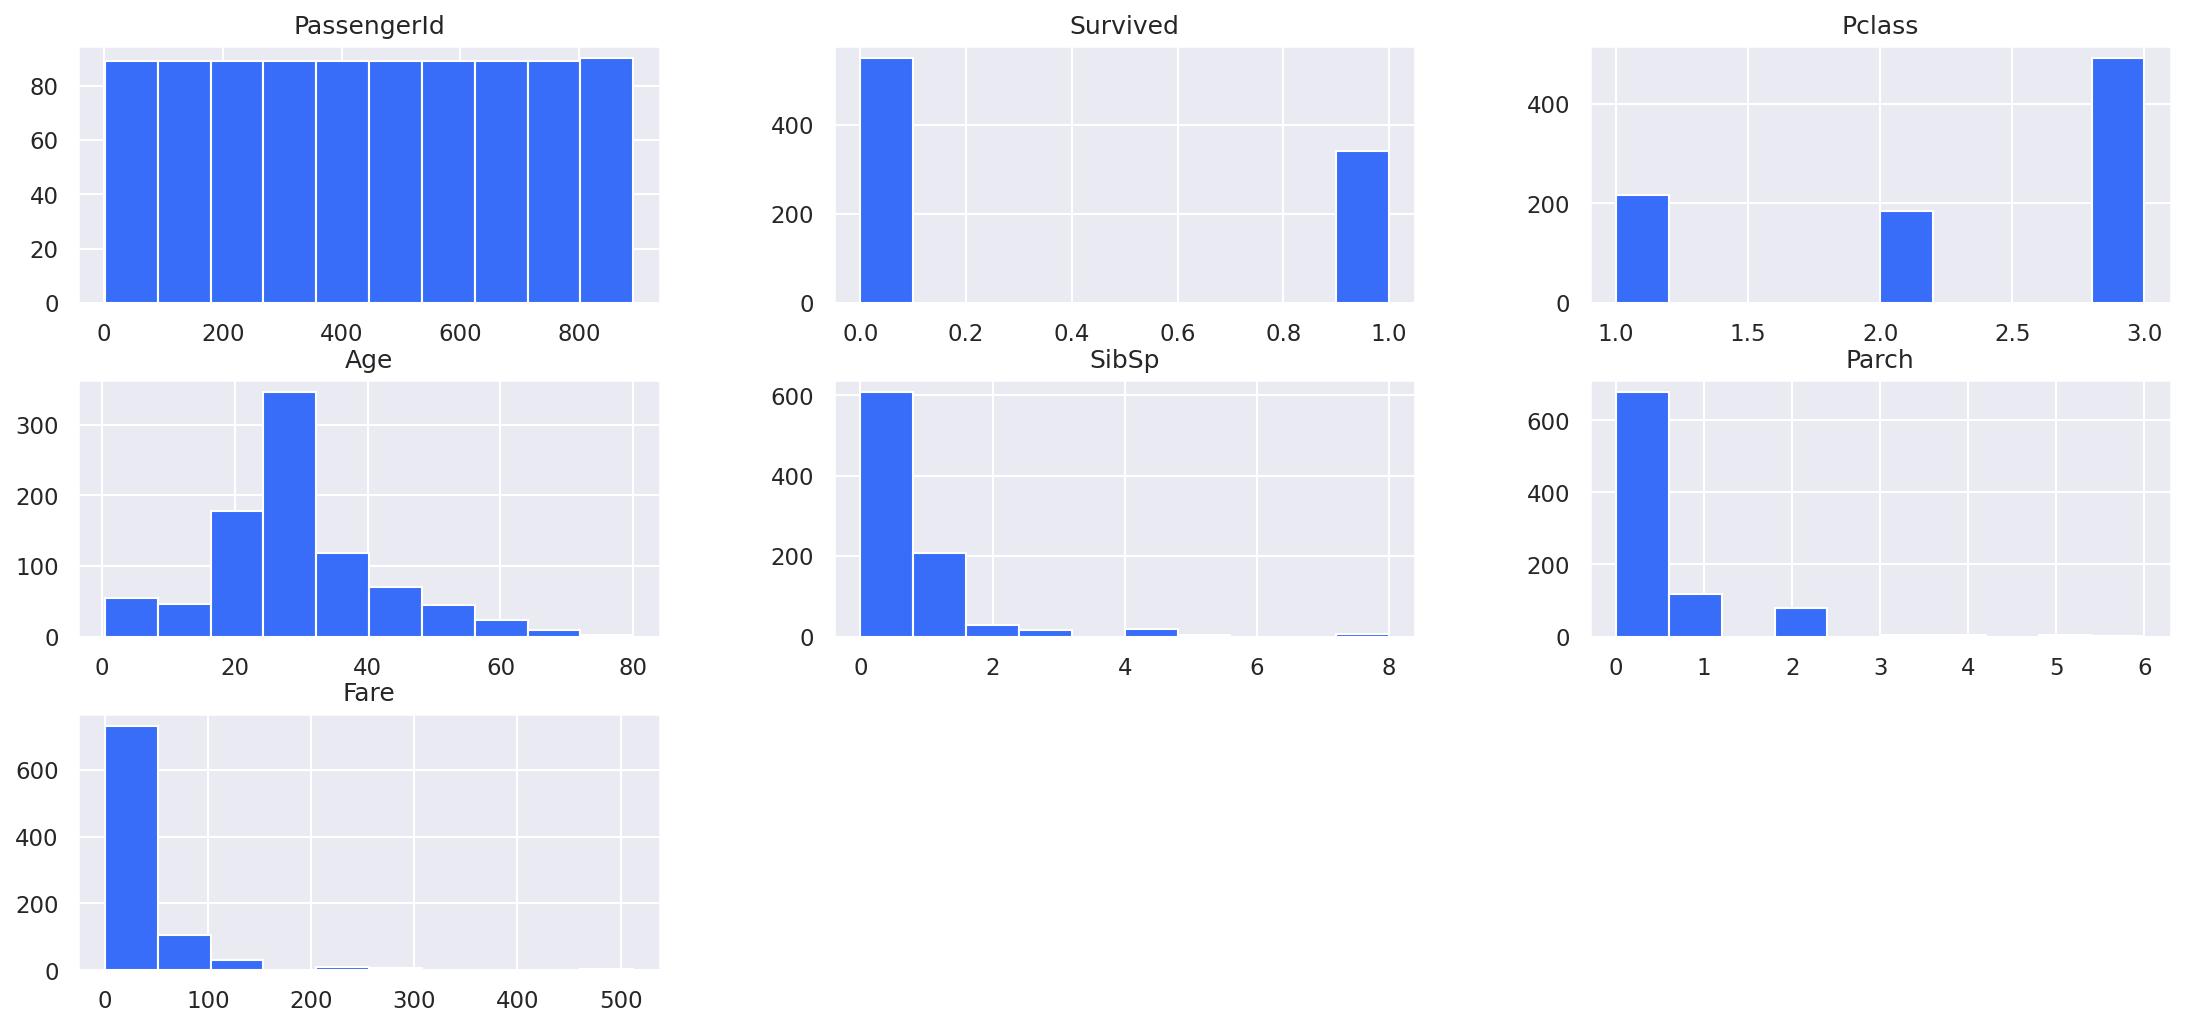

In [8]:
# @title $Histogram$

train_data.hist()

* Distribution of columns "SibSp", "Parch", "Fare" is skewed.

In [9]:
# @title $Column \ \ Types$
num_columns = [col for col in train_data.columns if train_data[col].dtype != 'O']
cat_columns = [col for col in train_data.columns if train_data[col].dtype == 'O']

print('Numerical Columns :', num_columns)
print('Categorical Columns :', cat_columns)

Numerical Columns : ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Columns : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


PassengerId


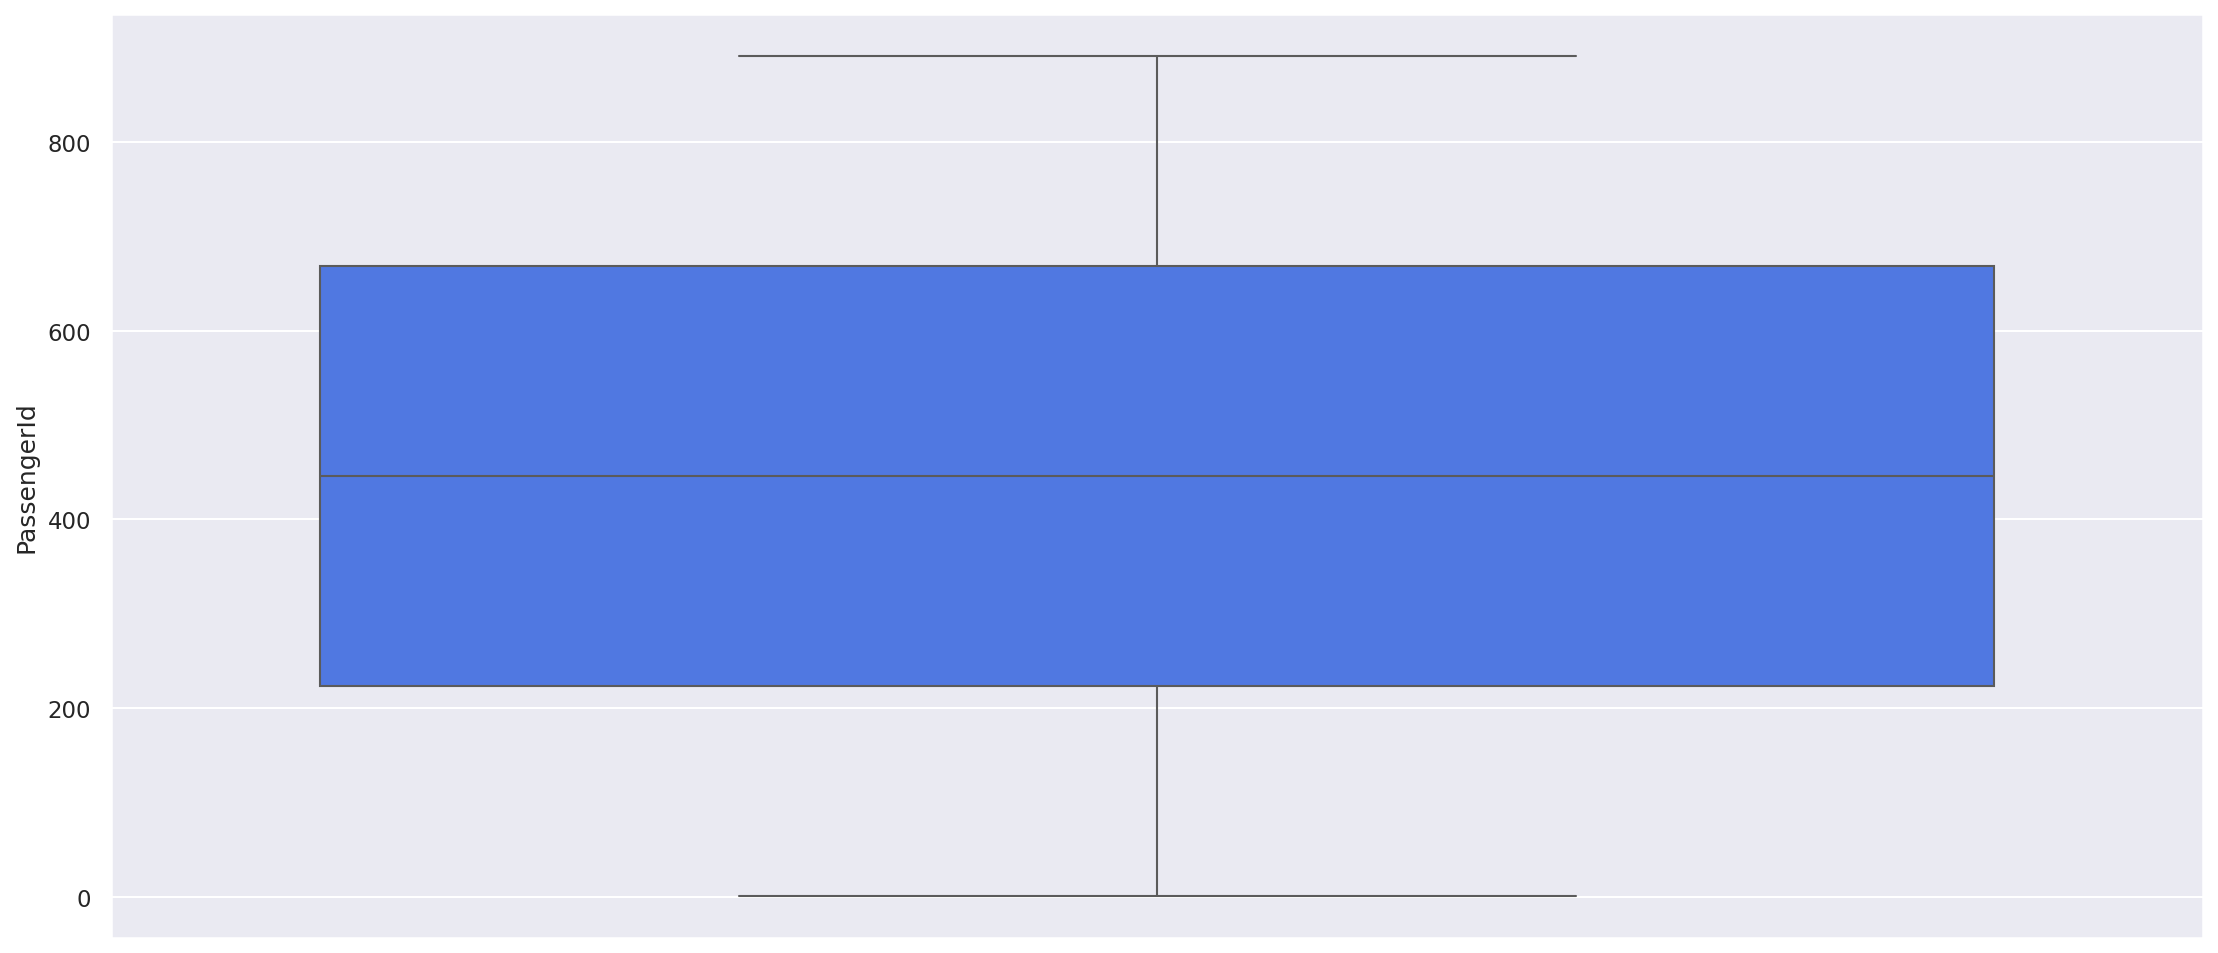


Survived


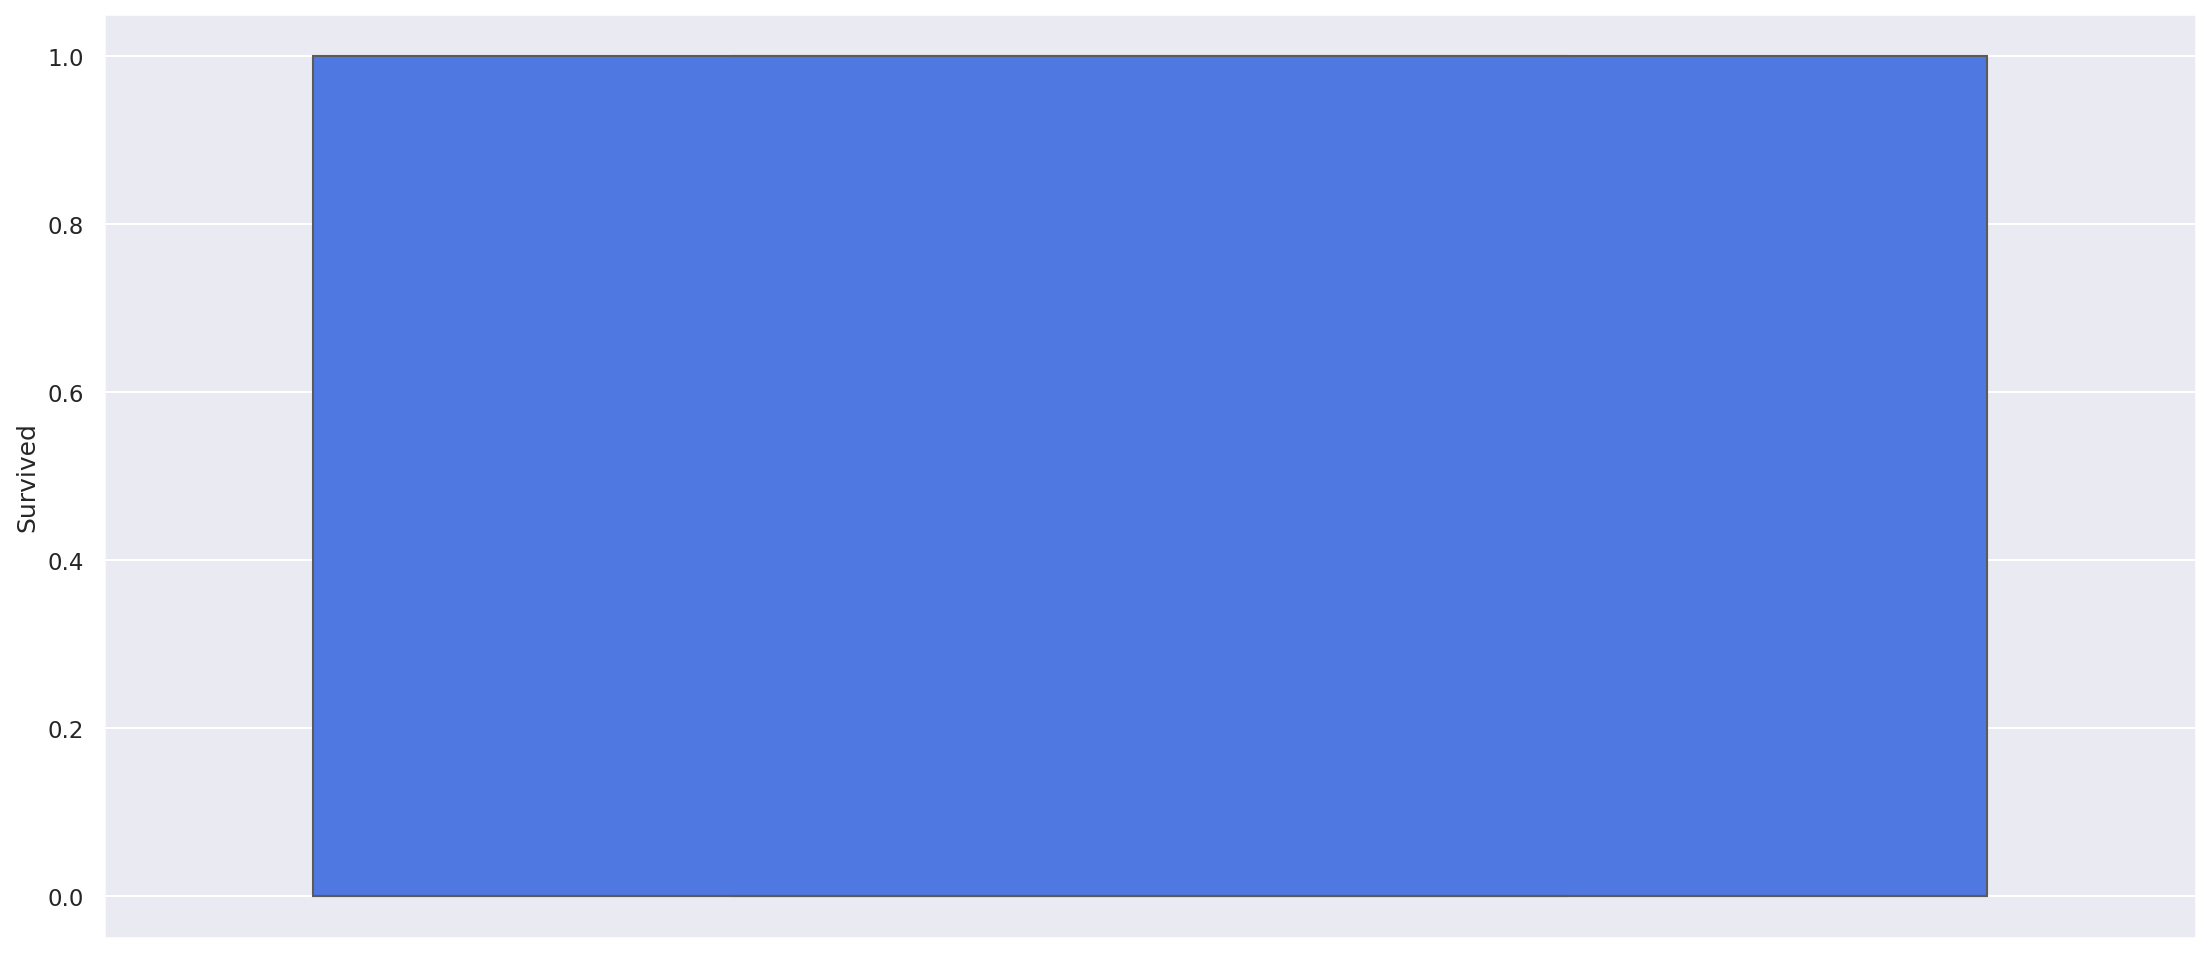


Pclass


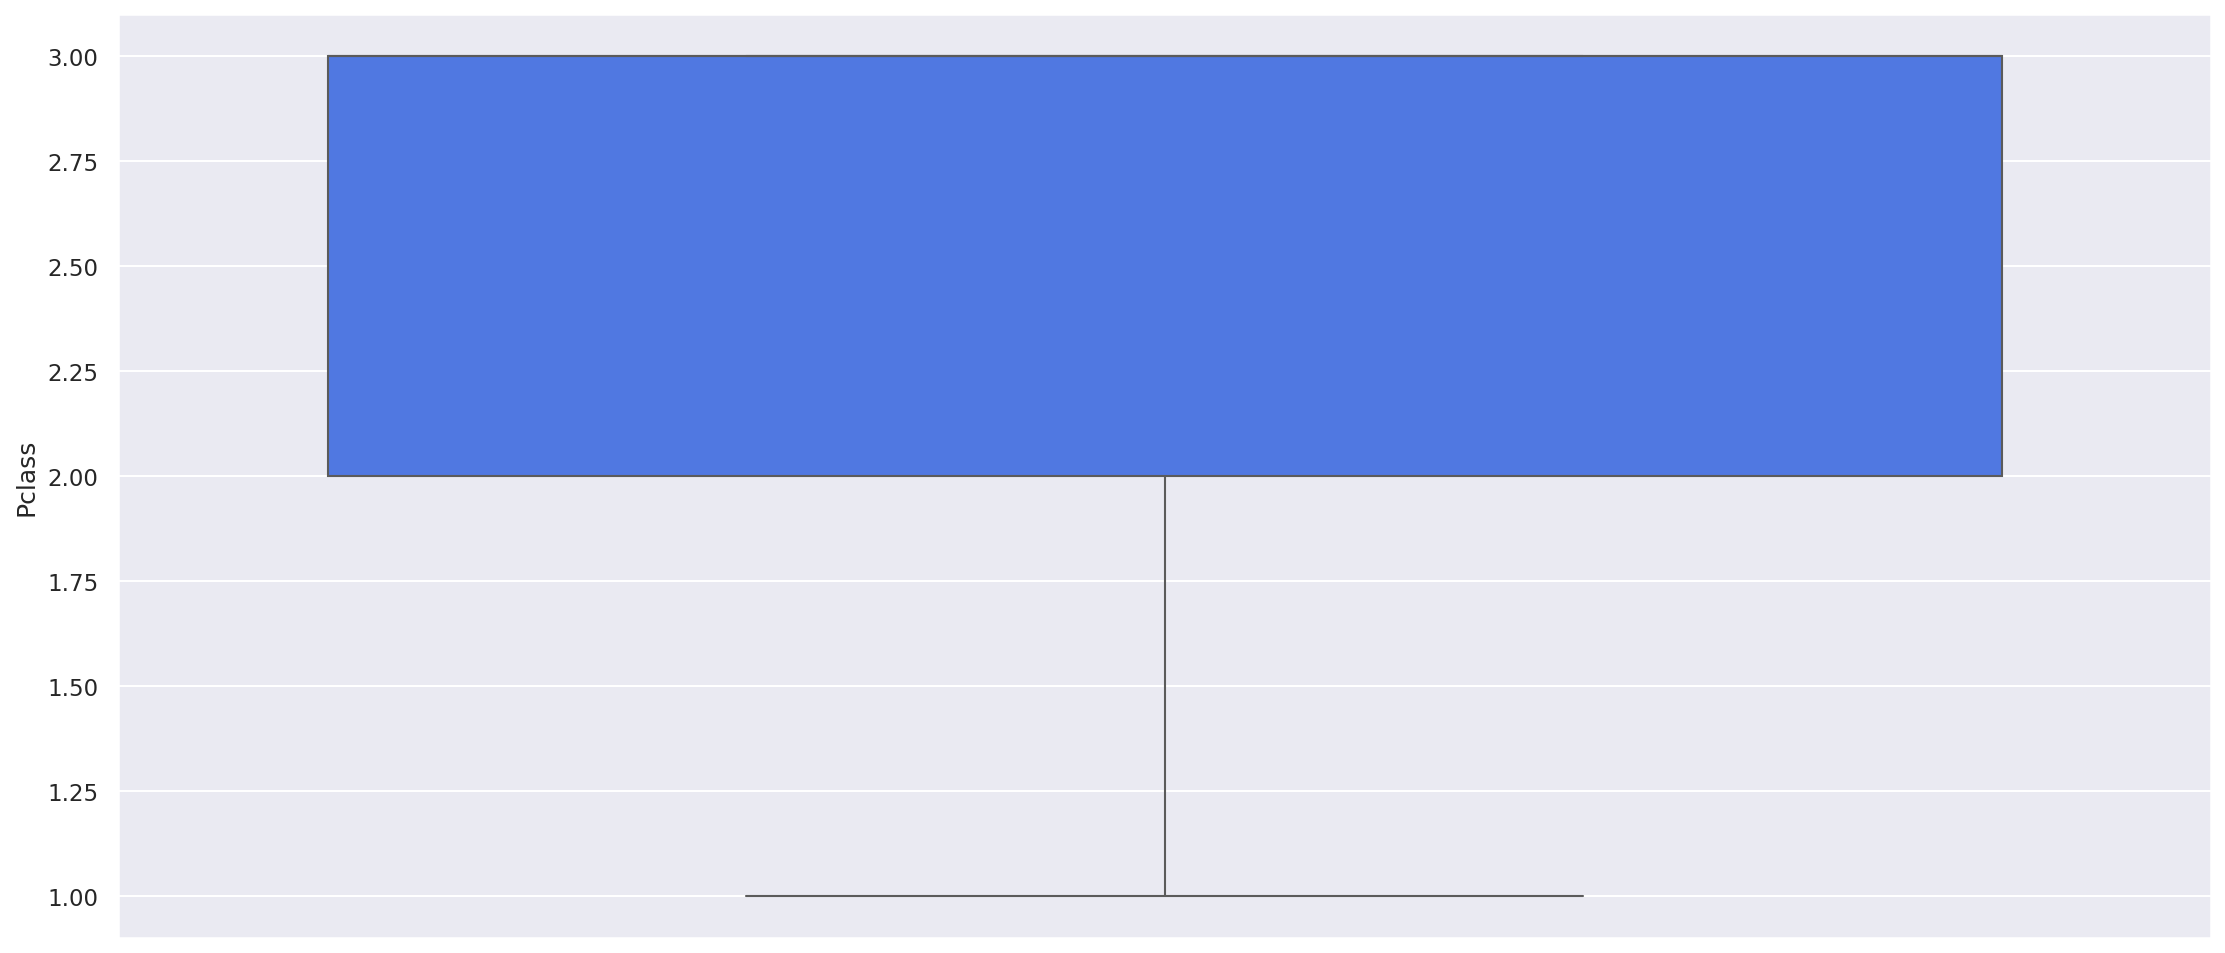


Age


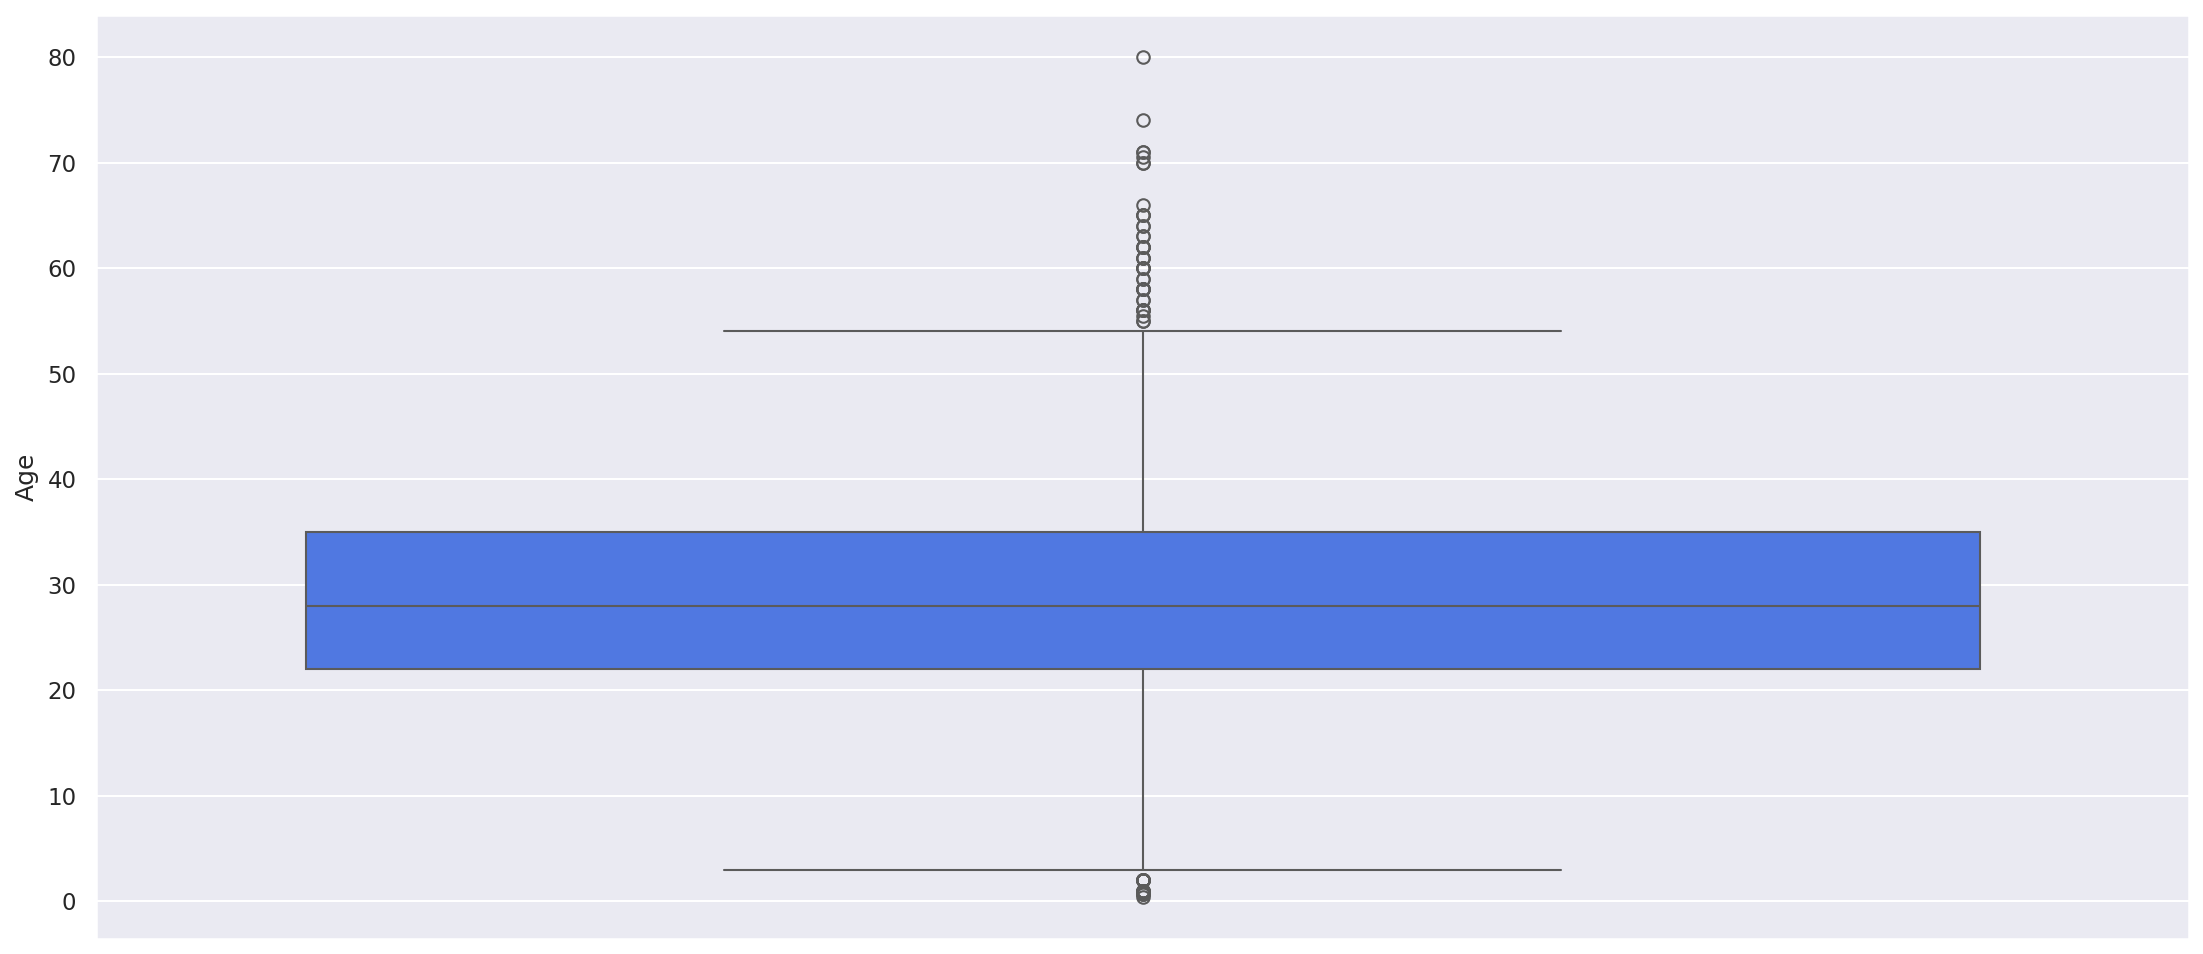


SibSp


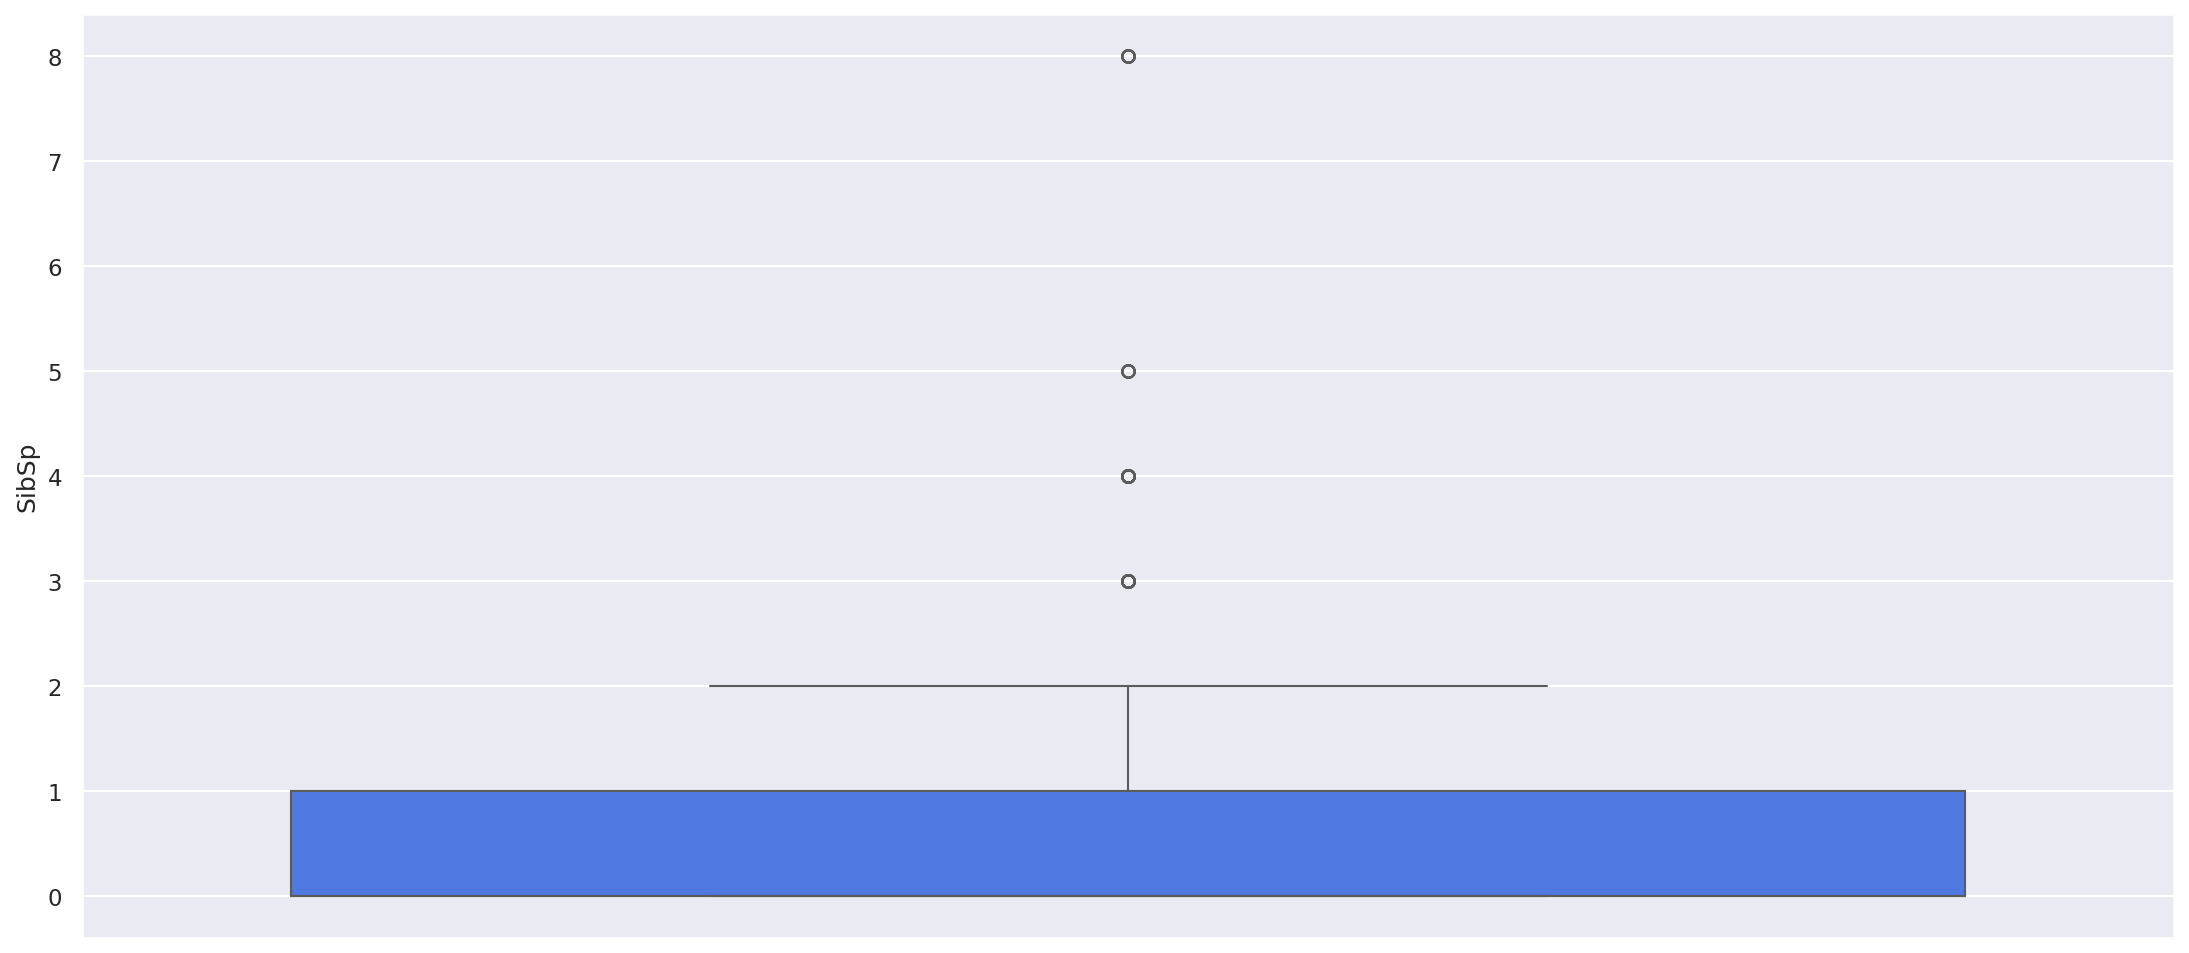


Parch


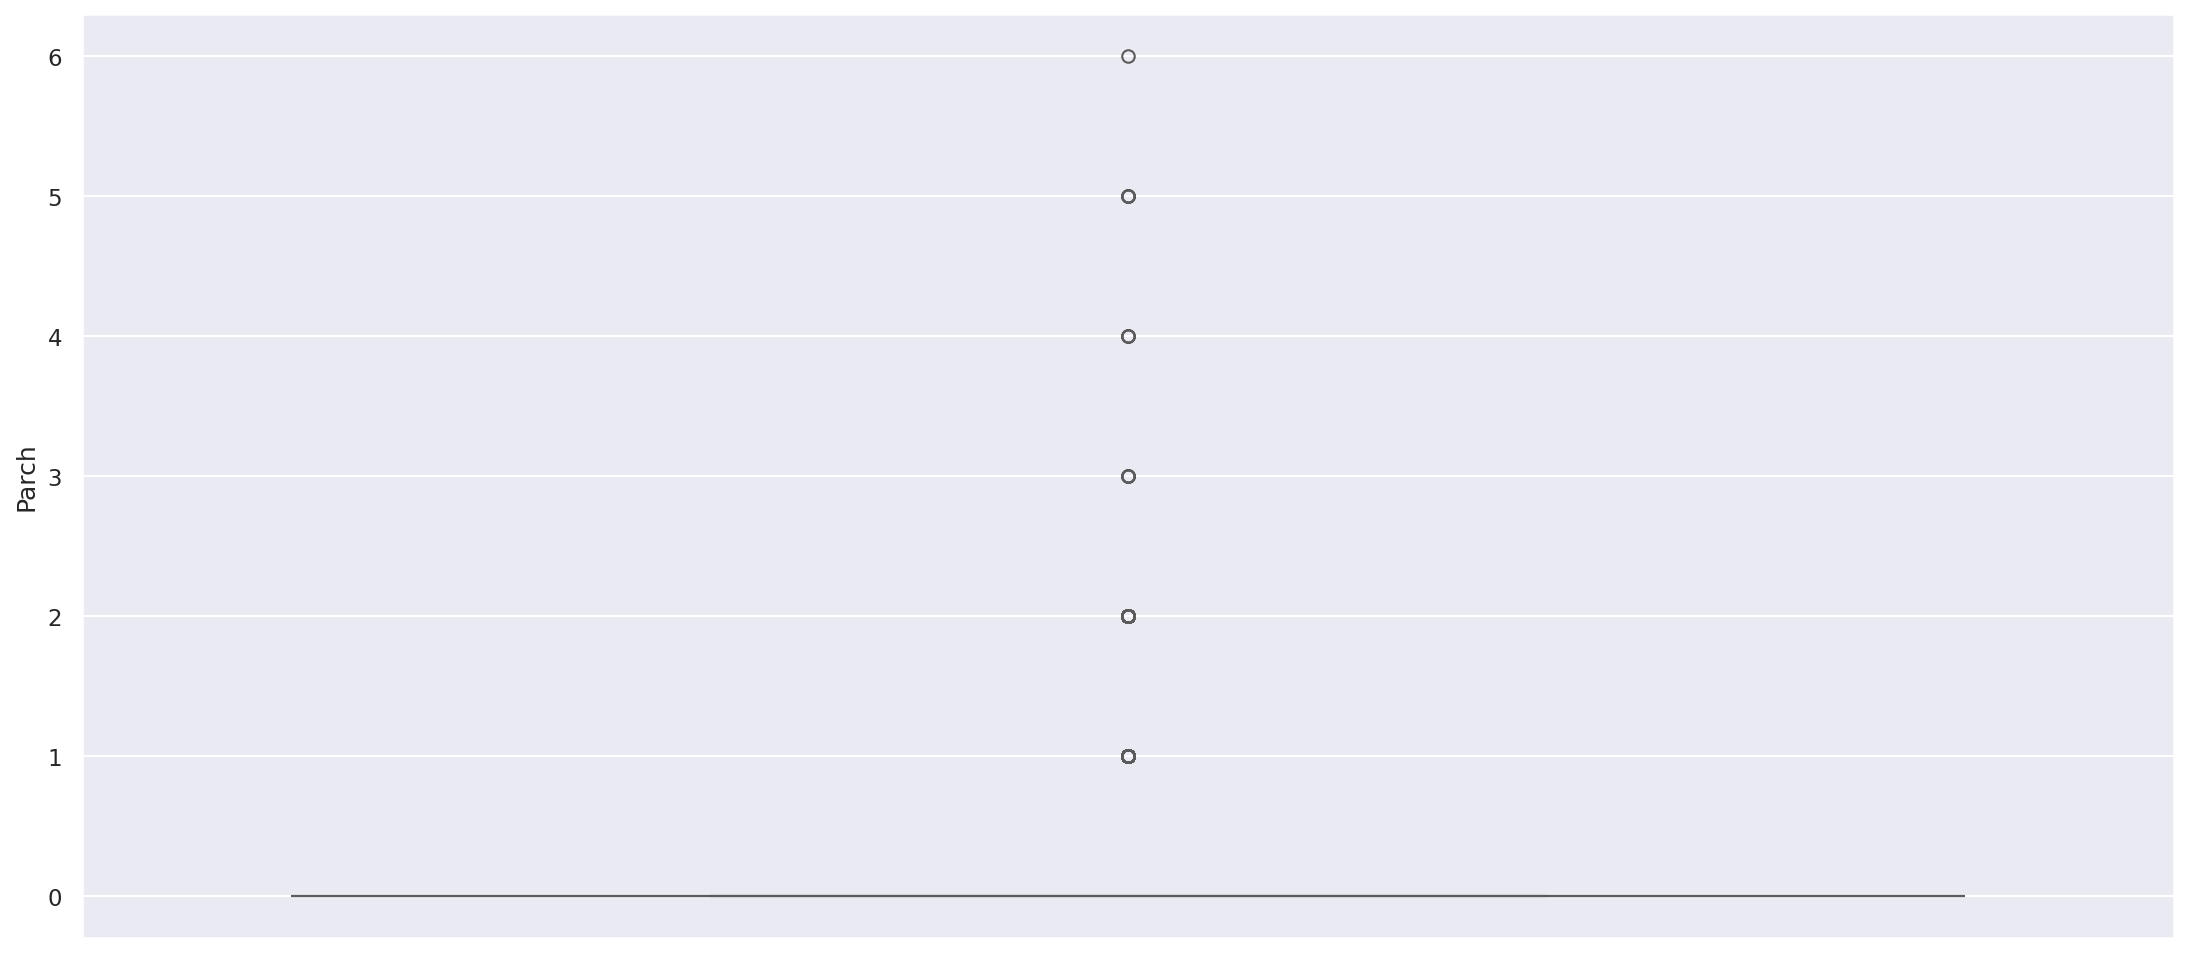


Fare


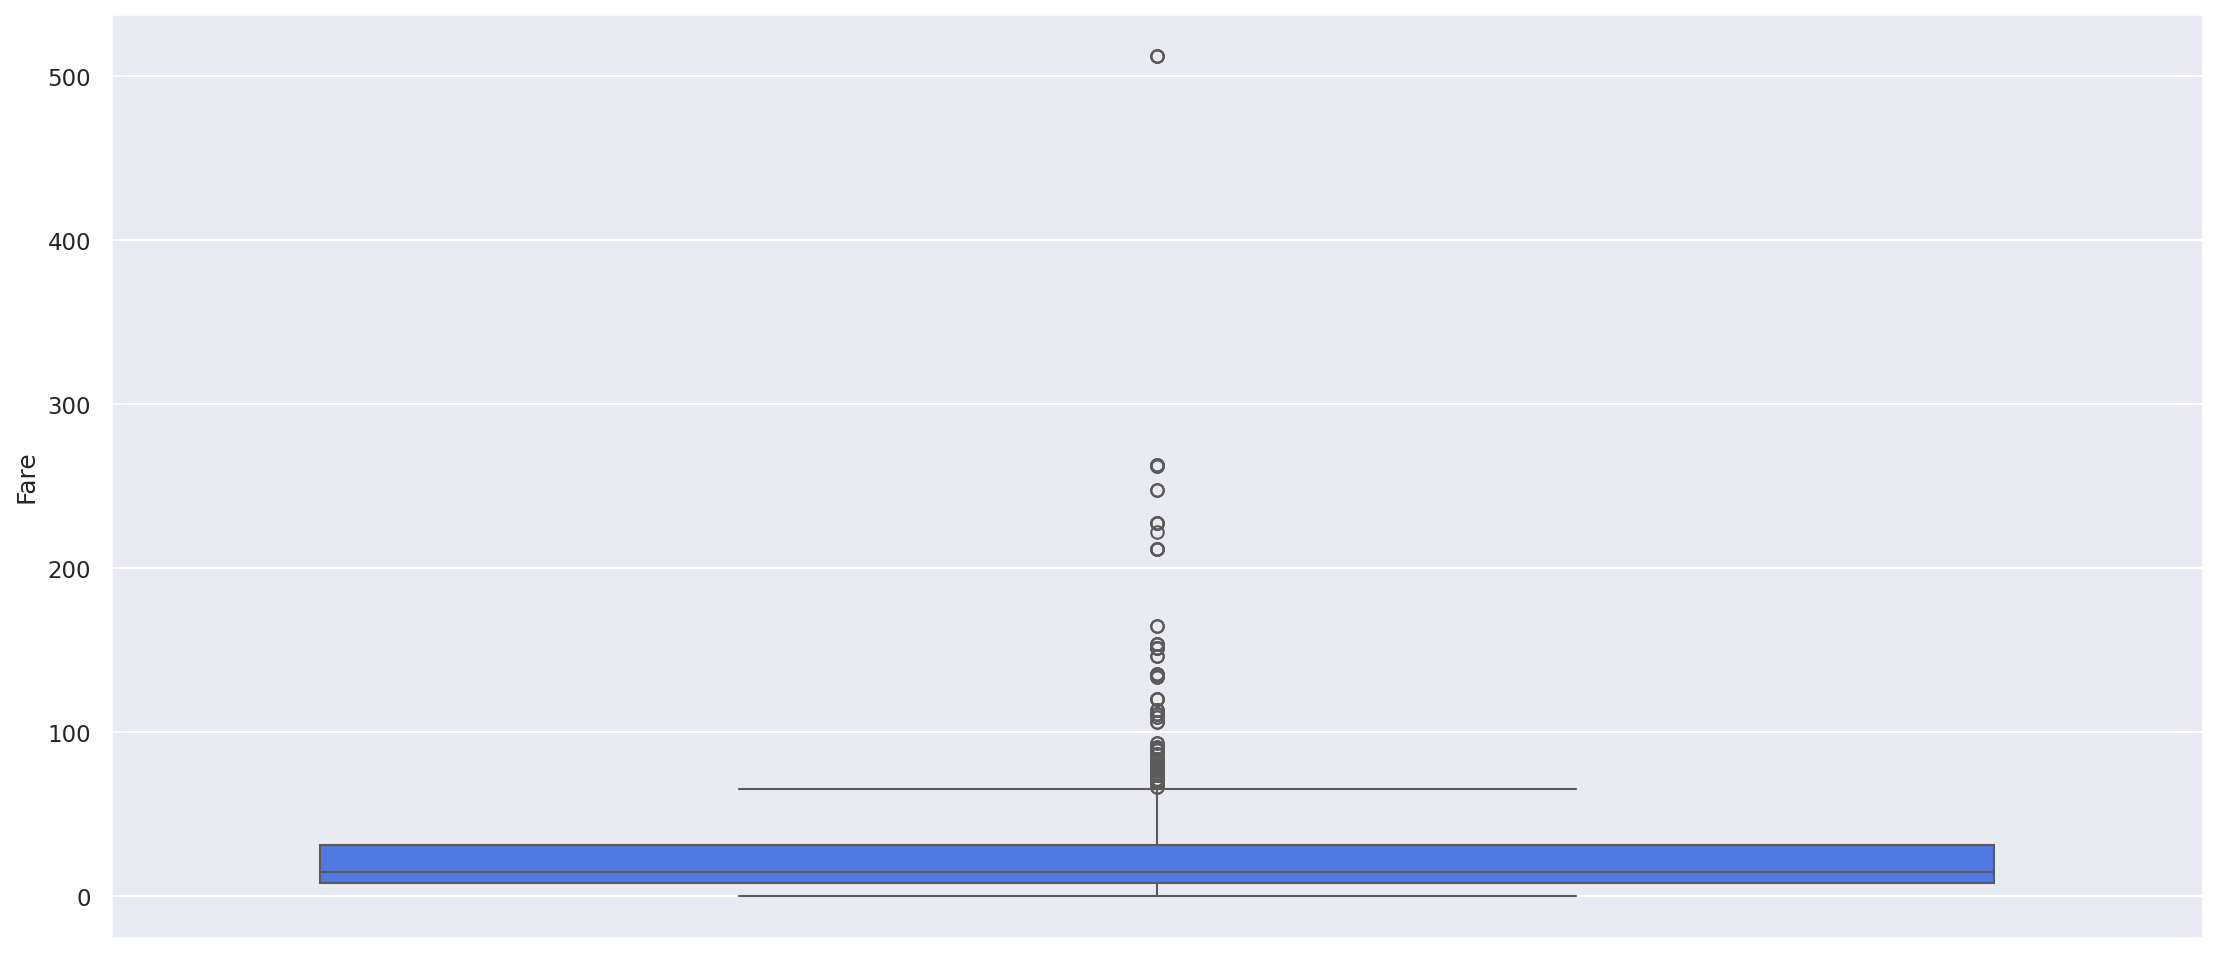

In [10]:
# @title $Boxplot$
for col in num_columns:
    print(col)
    sns.boxplot(train_data[col])
    plt.show()
    print()

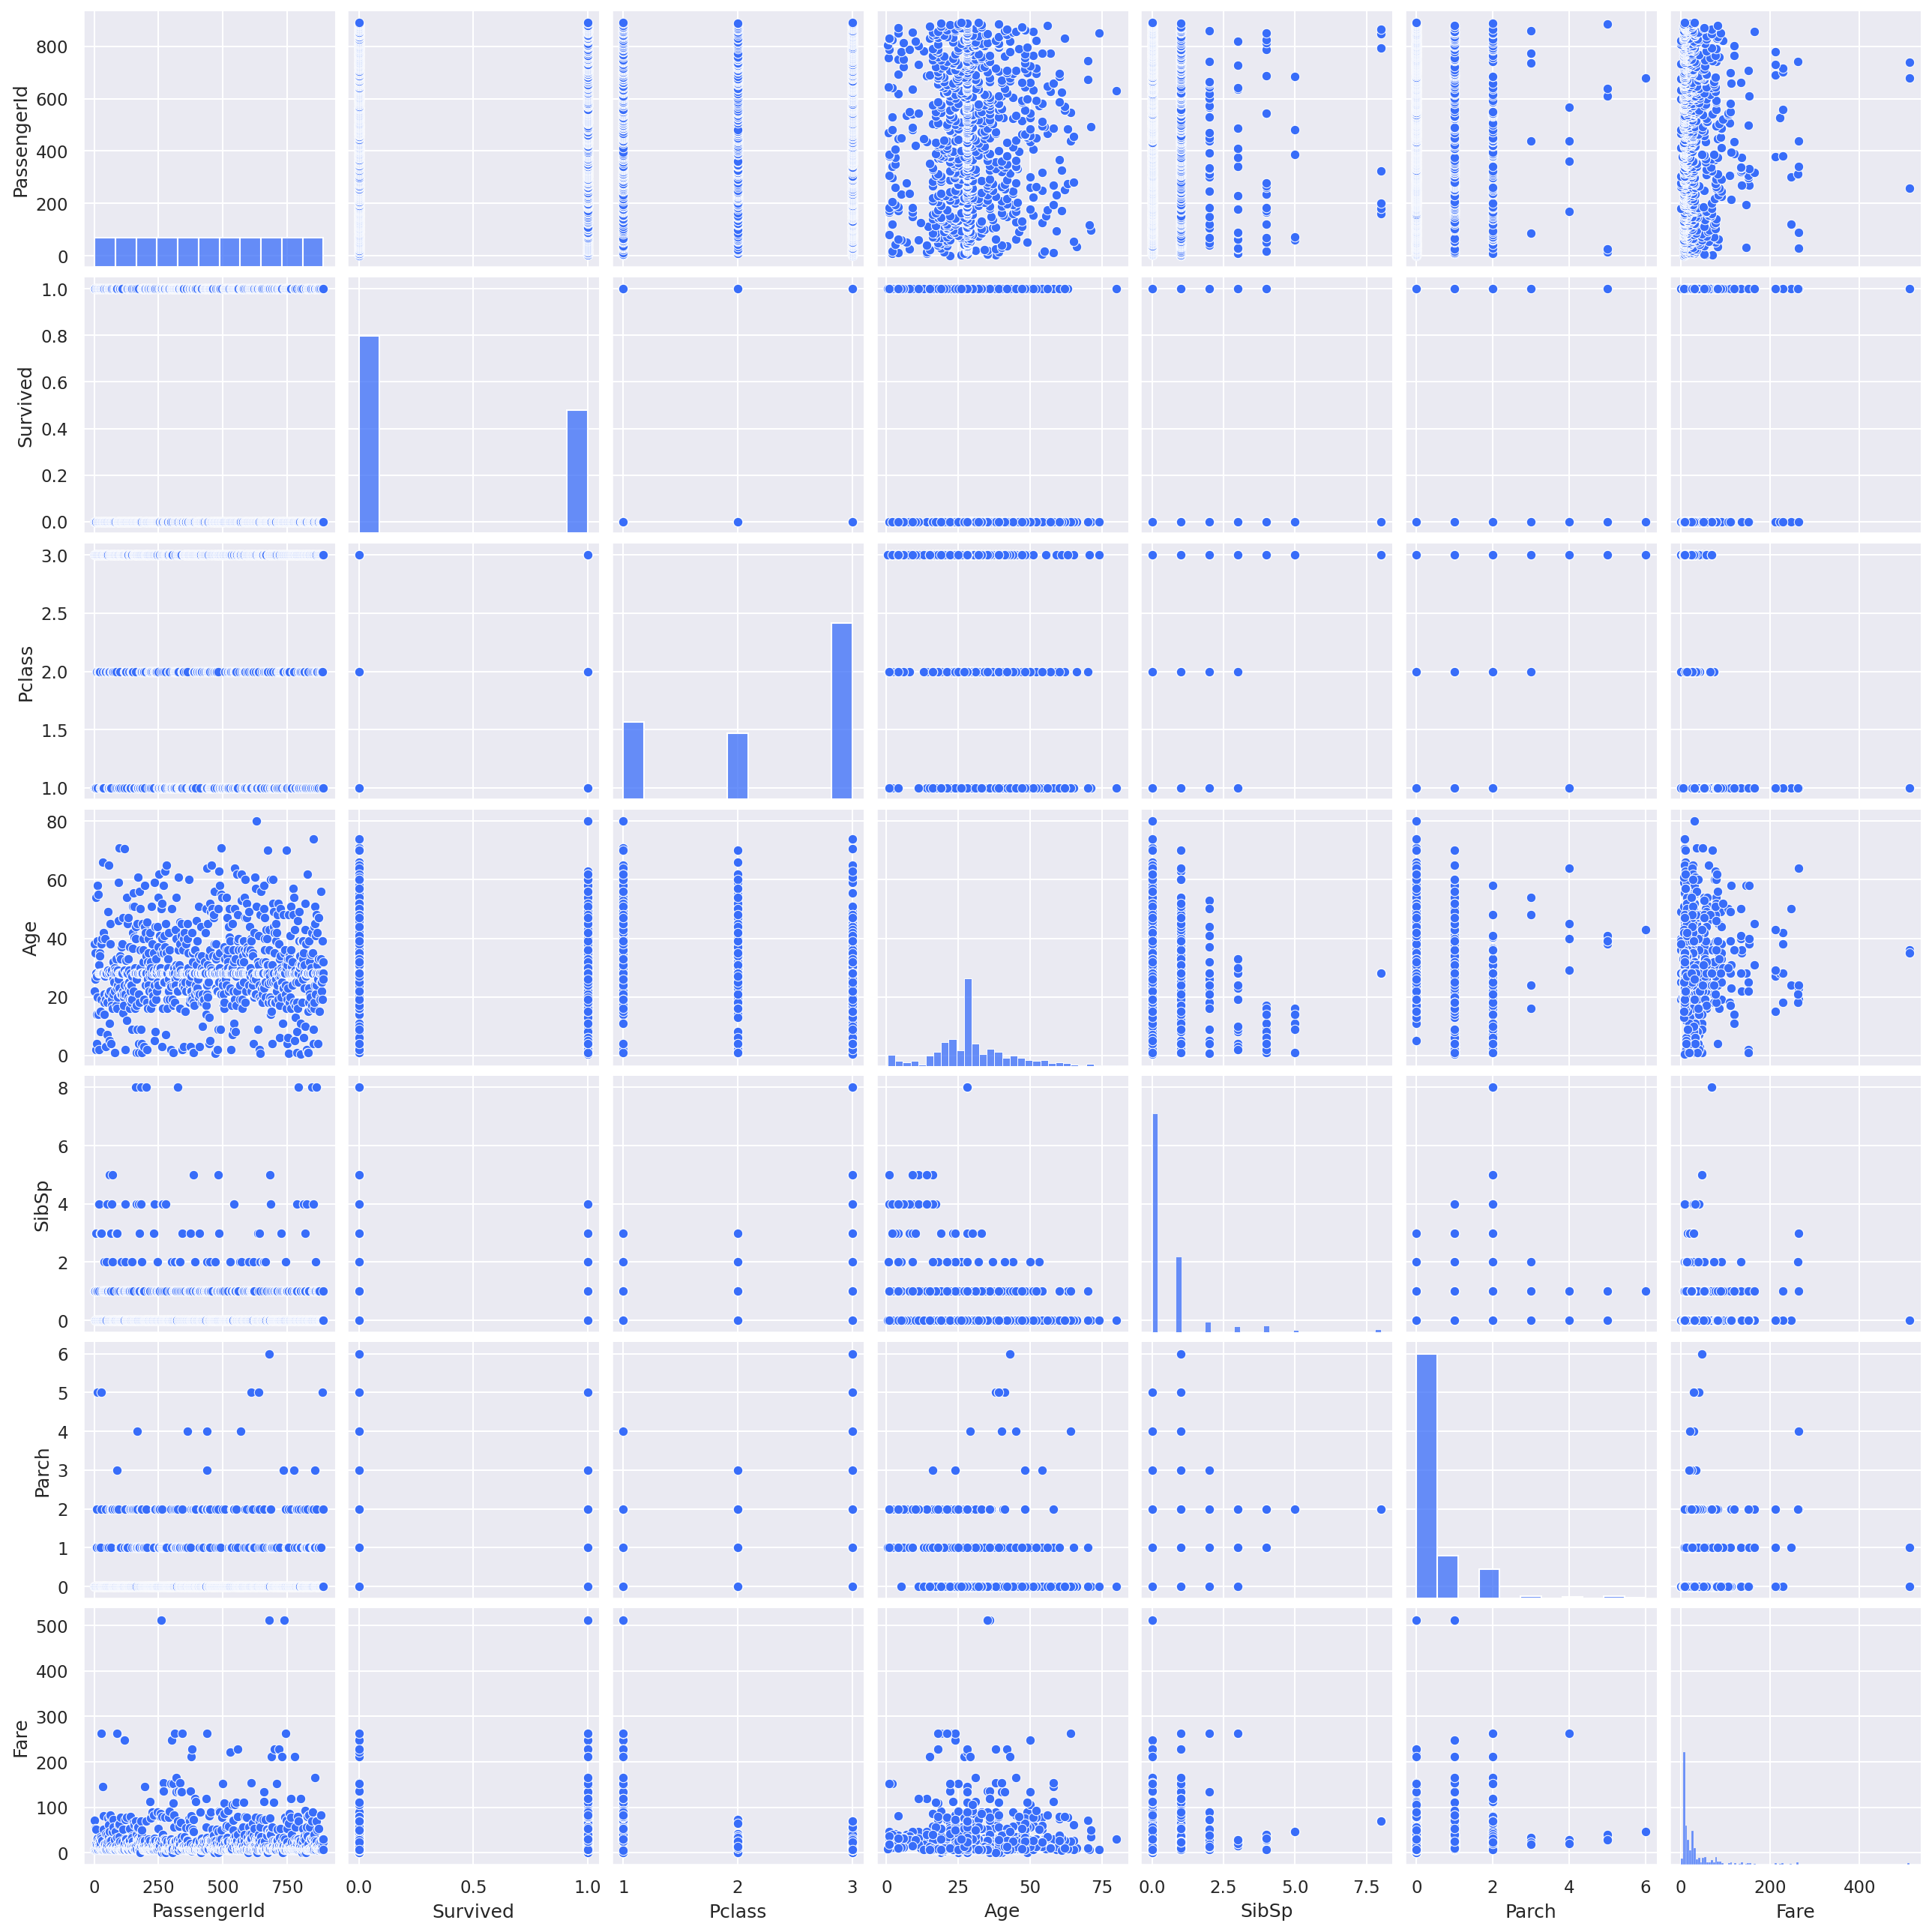

In [11]:
# @title $Pairplot$

sns.pairplot(train_data)

<Axes: >

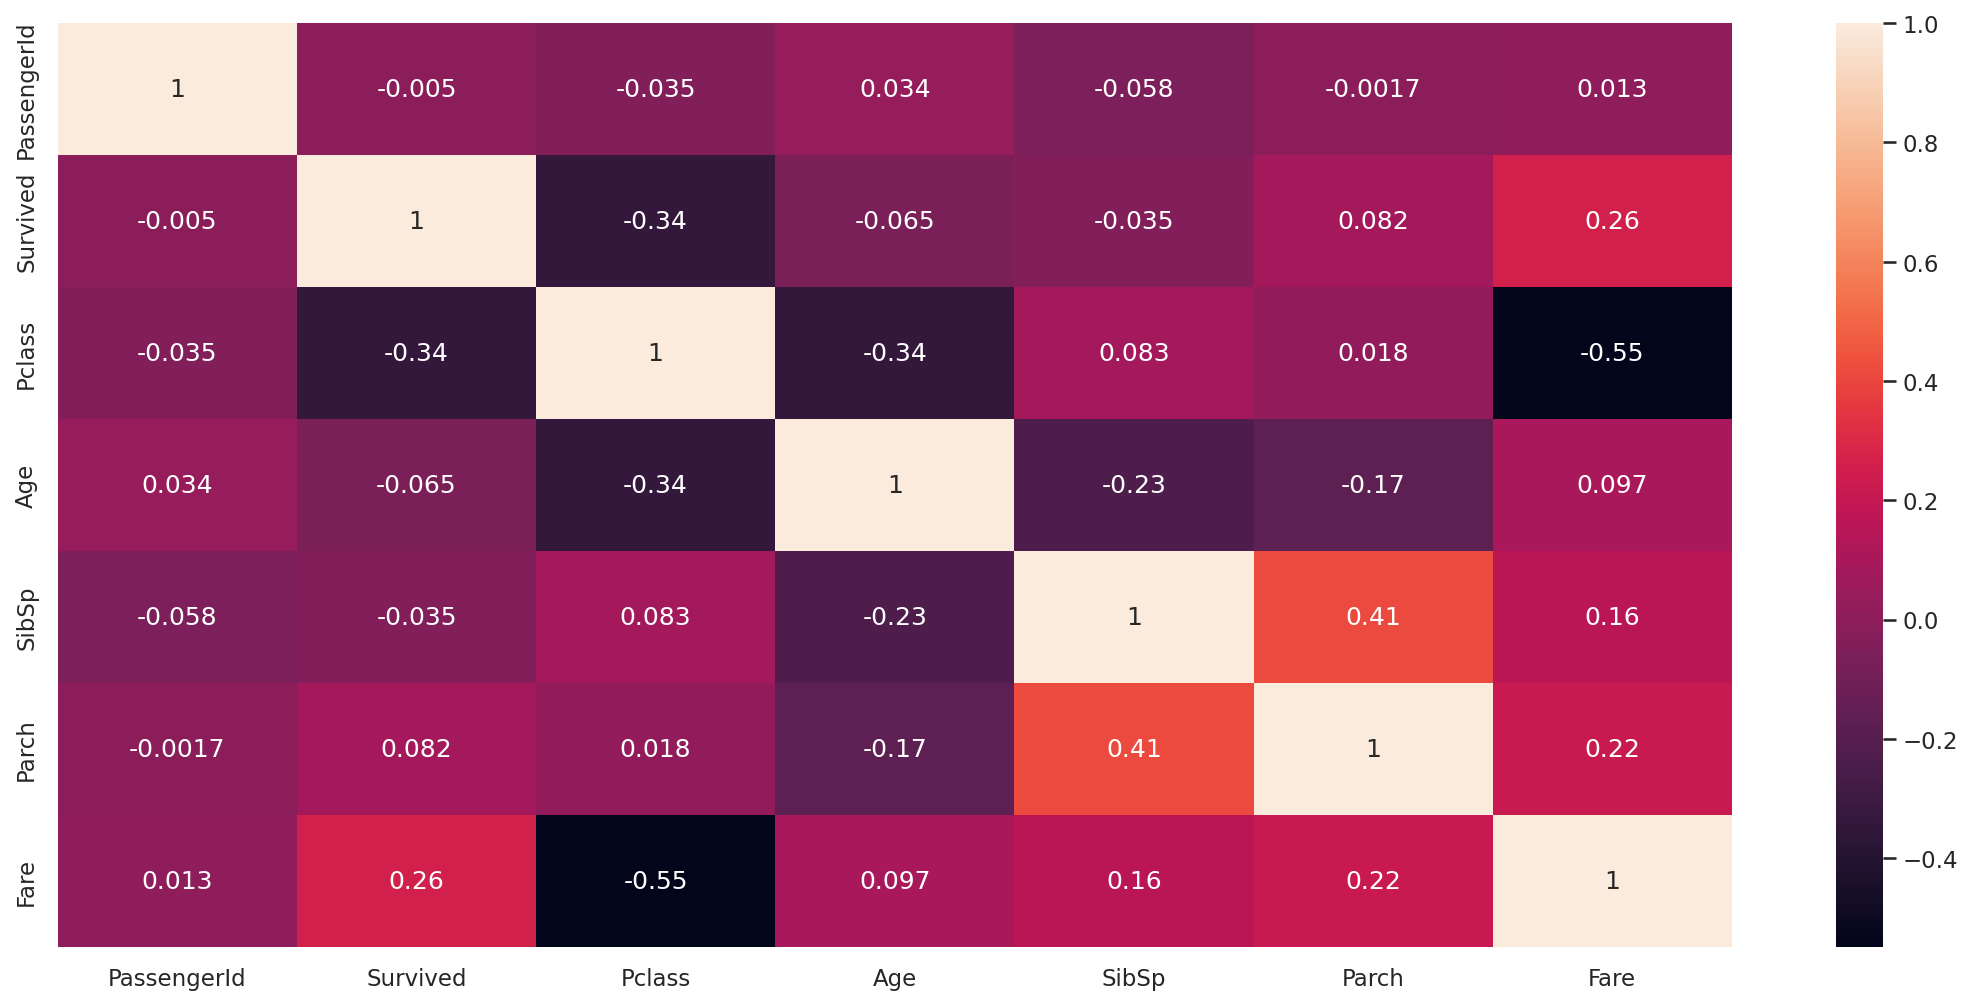

In [12]:
# @title $Correlation$

sns.heatmap(train_data[num_columns].corr(), annot=True)

In [13]:
# @title $Percentage \ \ of \ \ People \ \ Survived$
print(train_data['Survived'].value_counts())
print()

total_survived = train_data['Survived'].value_counts()[1]/(train_data['Survived'].value_counts()[0] + train_data['Survived'].value_counts()[1])*100
print(f'Percentage of people survived : {round(total_survived,2)}')

Survived
0    549
1    342
Name: count, dtype: int64

Percentage of people survived : 38.38


In [14]:
# @title $People \ \ who \ \ piad \ \ high \ \ fares \ \ and \ \ survived$
upper_extreme_Fare = train_data['Fare'].quantile(0.75) + 1.5 * (train_data['Fare'].quantile(0.75) - train_data['Fare'].quantile(0.25))
rich_survived = train_data[train_data['Fare']>=upper_extreme_Fare]['Survived'].value_counts()
print(rich_survived)
print()

print('Percentage of Rich people survived :', round(rich_survived[1]/(rich_survived[0] + rich_survived[1])*100,2))

Survived
1    79
0    37
Name: count, dtype: int64

Percentage of Rich people survived : 68.1


## Overall survival percenatge is 38.38%, but the  people who paid higher fares their survival percentage is 68.1%. This means priority is given to the rich people.

In [15]:
# @title $Data \ \ Description \ \ Object \ \ Type$

train_data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


# $2: Data \ \ Preprocessing:$

In [16]:
# @title $Convert \ \  Cabin \ \ Column \ \ into \ \ Binary$

train_data["Cabin"] = train_data["Cabin"].isna() # If cabin is there then 1, 0 for no cabin
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    bool   
 11  Embarked     889 non-null    object 
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 77.6+ KB


In [17]:
# @title $Fill \ \ NaN \ \ entries \ \ of \ \ Embarked \ \ column \ \ with \ \ median$
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    bool   
 11  Embarked     891 non-null    object 
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 77.6+ KB


In [18]:
# @title We will create a new column "Title" from an existing column "Name"
# Splitting based on Title
def get_title(name):
    if "." in name:
        return name.split(",")[1].split(".")[0].strip()
    else:
        return "Unknown"

def title_map(title):
    if title in ["Mr"]:
        return 1
    elif title in ["Master"]:
        return 3
    elif title in ["Ms", "Mlle", "Miss"]:
        return 4
    elif title in ["Mme","Mrs"]:
        return 5
    else:
        return 2

train_data["title"] = train_data["Name"].apply(get_title).apply(title_map)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    bool   
 11  Embarked     891 non-null    object 
 12  title        891 non-null    int64  
dtypes: bool(1), float64(2), int64(6), object(4)
memory usage: 84.5+ KB


## As the columns "PassengerID", "Name" and "Ticket" are not important for the prediction, we will drop these columns also

In [19]:
# @title $Drop \ \ Columns \ \ "PassengerId", \ \ "Name" \ \ and \ \ "Ticket" $
train_data = train_data.drop(["PassengerId","Name","Ticket"], axis="columns")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    bool   
 8   Embarked  891 non-null    object 
 9   title     891 non-null    int64  
dtypes: bool(1), float64(2), int64(5), object(2)
memory usage: 63.6+ KB


##$Encoding$

In [20]:
# @title $Label \ \  Encoding \ \ on \ \ column \ \ Sex$
le = LabelEncoder()

ec_train_data = train_data.copy()
ec_train_data['Sex']= le.fit_transform(ec_train_data['Sex'])
#ec_train_data['Embarked']= le.fit_transform(ec_train_data['Embarked'])
ec_train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title
0,0,3,1,22.0,1,0,7.2500,True,S,1
1,1,1,0,38.0,1,0,71.2833,False,C,5
2,1,3,0,26.0,0,0,7.9250,True,S,4
3,1,1,0,35.0,1,0,53.1000,False,S,5
4,0,3,1,35.0,0,0,8.0500,True,S,1


In [21]:
# @title $OneHotEncoding \ \ on \ \ column \ \ Embarked $

ec_train_data = pd.get_dummies(ec_train_data, columns=['Embarked'], dtype=int)
ec_train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,title,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,True,1,0,0,1
1,1,1,0,38.0,1,0,71.2833,False,5,1,0,0
2,1,3,0,26.0,0,0,7.9250,True,4,0,0,1
3,1,1,0,35.0,1,0,53.1000,False,5,0,0,1
4,0,3,1,35.0,0,0,8.0500,True,1,0,0,1


#$3: Building \ \ Predictive \ \ Models:$

In [22]:
# @title $Train-Test \ \ Split$

X = ec_train_data.drop('Survived', axis=1)
y = ec_train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print("Shapes")
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)

Shapes
X_train : (712, 11)
X_test  : (179, 11)
y_train : (712,)
y_test  : (179,)


##$Gradient \ \ Boosting \ \ Classifier$

In [23]:
# @title $Function \ \ for \ \ Final \ \ Model \ \ Performance$

def final_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    print(f"1) Train Accuracy : {model.score(X_train,y_train)}")

    print(f"2) Test Accuracy : {model.score(X_test,y_test)}")

    print('3) Classification Report :')
    print(classification_report(y_test,y_pred))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('4) ROC_AUC Score :', roc_auc)
    print("5) Survived :", sum(y_pred!=0))
    print("6) Not Survived : ", sum(y_pred==0))

    print()
    print('7) Confusion Matrix :')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

In [24]:
# @title $Model$

final_model(GradientBoostingClassifier(random_state=1234))

1) Train Accuracy : 0.9058988764044944
2) Test Accuracy : 0.8547486033519553
3) Classification Report :
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       109
           1       0.87      0.74      0.80        70

    accuracy                           0.85       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.85      0.85       179

4) ROC_AUC Score : 0.8347313237221494
5) Survived : 60
6) Not Survived :  119

7) Confusion Matrix :
[[101   8]
 [ 18  52]]


## $Light \ \ Gradient \ \ Booster \ \ Model$

In [25]:
# @title $LGBM$

import lightgbm as lgb

final_model(lgb.LGBMClassifier(verbose=-1 ,random_state=1234))

1) Train Accuracy : 0.9550561797752809
2) Test Accuracy : 0.8100558659217877
3) Classification Report :
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       109
           1       0.76      0.76      0.76        70

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

4) ROC_AUC Score : 0.8005897771952818
5) Survived : 70
6) Not Survived :  109

7) Confusion Matrix :
[[92 17]
 [17 53]]


## $Light \ \ Gradient \ \ Booster \ \ Model \ \ Using \ \ RandomizedSearchCV$

In [26]:
# @title $Hyperparameter \ \ Tunnig$
model = lgb.LGBMClassifier(verbose=-1, random_state=1234)
random_grid = { 'eta': [x for x in np.linspace(start=0.0, stop=0.5, num=12)],
               'n_estimators': [0,1,5,10,20,30,40,50,60,70,80,90,100,110,500,1000],
                'max_depth':range(0,10,1),
                'max_leaves':range(0,21,1),
                'tree_method':['auto', 'exact', 'approx', 'hist'],
                'colsample_bytree': [i/100.0 for i in range (91, 100, 1)],
                'min_child_weight': range(1,15,1),
                'gamma': [i/10.0 for i in range (0,5)],
                'subsample': [i/100.0 for i in range (60, 100, 5)],
                'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
                'learning_rate': [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
                }

In [27]:
# @title $Best \ \ Parameters$
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, cv = 5)

rf_random.fit(X_train, y_train)
print('Best Score :',rf_random.best_score_)
rf_random.best_params_

Best Score : 0.8287008765882007


{'tree_method': 'auto',
 'subsample': 0.7,
 'reg_alpha': 0,
 'n_estimators': 100,
 'min_child_weight': 8,
 'max_leaves': 0,
 'max_depth': 7,
 'learning_rate': 1,
 'gamma': 0.1,
 'eta': 0.2272727272727273,
 'colsample_bytree': 0.94}

In [28]:
# @title $LGBMClassifier \ \ with \ \ best \ \ parameters$
model1 = lgb.LGBMClassifier(verbose=-1,
                            random_state=1234,
                            tree_method='hist',
                          subsample=0.75,
                          reg_alpha=0.001,
                          n_estimators=1000,
                          min_child_weight=10,
                          max_leaves=11,
                          max_depth=2,
                          learning_rate=0.1,
                          gamma=0.3,
                          eta=0.2272727272727273,
                          colsample_bytree=0.97)


final_model(model1)

1) Train Accuracy : 0.8862359550561798
2) Test Accuracy : 0.8379888268156425
3) Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.93      0.87       109
           1       0.86      0.70      0.77        70

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179

4) ROC_AUC Score : 0.813302752293578
5) Survived : 57
6) Not Survived :  122

7) Confusion Matrix :
[[101   8]
 [ 21  49]]


## $Light \ \ Gradient \ \ Booster \ \ Model \ \ Using \ \ GridSearchCV$

In [29]:
# @title $Function \ \ for \ \ Hyperparameter \ \ Tunning \ \ using \ \ GridSearchCV$
def hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test):
    rf_random = GridSearchCV(model, random_grid, cv=5)
    rf_random.fit(X_train, y_train)
    y_pred = rf_random.predict(X_test)
    print(f"1) Train Accuracy : {rf_random.score(X_train,y_train)}")
    print(f"2) Test Accuracy : {rf_random.score(X_test,y_test)}")
    print('3) Classification Report')
    print(classification_report(y_test,y_pred))
    print("4) Best Score :", rf_random.best_score_)
    print("5) Best Parameters :",rf_random.best_params_)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    roc_auc
    print('6) ROC_AUC Score :', roc_auc)
    print(f"7) Confusion matrix : \n {confusion_matrix(y_test, y_pred)}\n")

In [30]:
# @title $Hyperparameter \ \ Tunning $
model = lgb.LGBMClassifier(objective="binary", verbose=-1 ,random_state=1234)
random_grid = {}

hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9550561797752809
2) Test Accuracy : 0.8100558659217877
3) Classification Report
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       109
           1       0.76      0.76      0.76        70

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

4) Best Score : 0.8146656160740668
5) Best Parameters : {}
6) ROC_AUC Score : 0.8005897771952818
7) Confusion matrix : 
 [[92 17]
 [17 53]]



In [31]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ eta$
model = lgb.LGBMClassifier(objective="binary", verbose=-1 ,random_state=1234)
random_grid = {'eta': [x for x in np.linspace(start=0.0, stop=0.5, num=12)]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9550561797752809
2) Test Accuracy : 0.8100558659217877
3) Classification Report
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       109
           1       0.76      0.76      0.76        70

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

4) Best Score : 0.8146656160740668
5) Best Parameters : {'eta': 0.0}
6) ROC_AUC Score : 0.8005897771952818
7) Confusion matrix : 
 [[92 17]
 [17 53]]



In [32]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ n-estimators$
model = lgb.LGBMClassifier(objective="binary", verbose=-1 ,random_state=1234)
random_grid = {'n_estimators': [0,1,5,10,20,30,40,50,60,70,80,90,100,110,500,1000]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9101123595505618
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       109
           1       0.82      0.73      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8245050723923963
5) Best Parameters : {'n_estimators': 50}
6) ROC_AUC Score : 0.813826998689384
7) Confusion matrix : 
 [[98 11]
 [19 51]]



In [33]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ max\_depth$
model = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50)
random_grid = {'max_depth':range(0,10,1)}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8329065300896288
5) Best Parameters : {'max_depth': 8}
6) ROC_AUC Score : 0.8112712975098297
7) Confusion matrix : 
 [[99 10]
 [20 50]]



In [34]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ max\_leaves$
model = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50, max_depth=8)
random_grid = {'max_leaves':range(0,21,1)}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8329065300896288
5) Best Parameters : {'max_leaves': 0}
6) ROC_AUC Score : 0.8112712975098297
7) Confusion matrix : 
 [[99 10]
 [20 50]]



In [35]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ tree\_method$
model = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50, max_depth=8)
random_grid = {'tree_method':['auto', 'exact', 'approx', 'hist']}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8329065300896288
5) Best Parameters : {'tree_method': 'auto'}
6) ROC_AUC Score : 0.8112712975098297
7) Confusion matrix : 
 [[99 10]
 [20 50]]



In [36]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ colsample\_bytree$
model = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50, max_depth=8, tree_method='auto')
random_grid = {'colsample_bytree': [i/100.0 for i in range (91, 100, 1)]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8329065300896288
5) Best Parameters : {'colsample_bytree': 0.96}
6) ROC_AUC Score : 0.8112712975098297
7) Confusion matrix : 
 [[99 10]
 [20 50]]



In [37]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ gamma$
model = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50, max_depth=8, colsample_bytree=0.96)
random_grid = {'gamma': [i/10.0 for i in range (0,5)]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8329065300896288
5) Best Parameters : {'gamma': 0.0}
6) ROC_AUC Score : 0.8112712975098297
7) Confusion matrix : 
 [[99 10]
 [20 50]]



In [38]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ learning\_rate$
model = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50, max_depth=8, colsample_bytree=0.96)
random_grid = {'learning_rate': [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8329065300896288
5) Best Parameters : {'learning_rate': 0.1}
6) ROC_AUC Score : 0.8112712975098297
7) Confusion matrix : 
 [[99 10]
 [20 50]]



In [39]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ min\_child\_weight$
model = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50, max_depth=8, colsample_bytree=0.96)
random_grid = {'min_child_weight': range(1,15,1)}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8231064709937949
5) Best Parameters : {'min_child_weight': 1}
6) ROC_AUC Score : 0.8112712975098297
7) Confusion matrix : 
 [[99 10]
 [20 50]]



In [40]:
# @title $Final \ \ Light \ \ Gradient \ \ Booster \ \ Model \ \ Using \ \ GridSearchCV$
model2 = lgb.LGBMClassifier(objective="binary",verbose=-1 ,random_state=1234, n_estimators=50, max_depth=8, colsample_bytree=0.96)

final_model(model2)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) ROC_AUC Score : 0.8112712975098297
5) Survived : 60
6) Not Survived :  119

7) Confusion Matrix :
[[99 10]
 [20 50]]


#$Extreme \ \ Gradient \ \ Booster \ \ Model$

In [41]:
# @title $Model$

final_model(XGBClassifier(random_state=1234))

1) Train Accuracy : 0.9775280898876404
2) Test Accuracy : 0.8379888268156425
3) Classification Report :
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       109
           1       0.79      0.80      0.79        70

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

4) ROC_AUC Score : 0.8311926605504587
5) Survived : 71
6) Not Survived :  108

7) Confusion Matrix :
[[94 15]
 [14 56]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

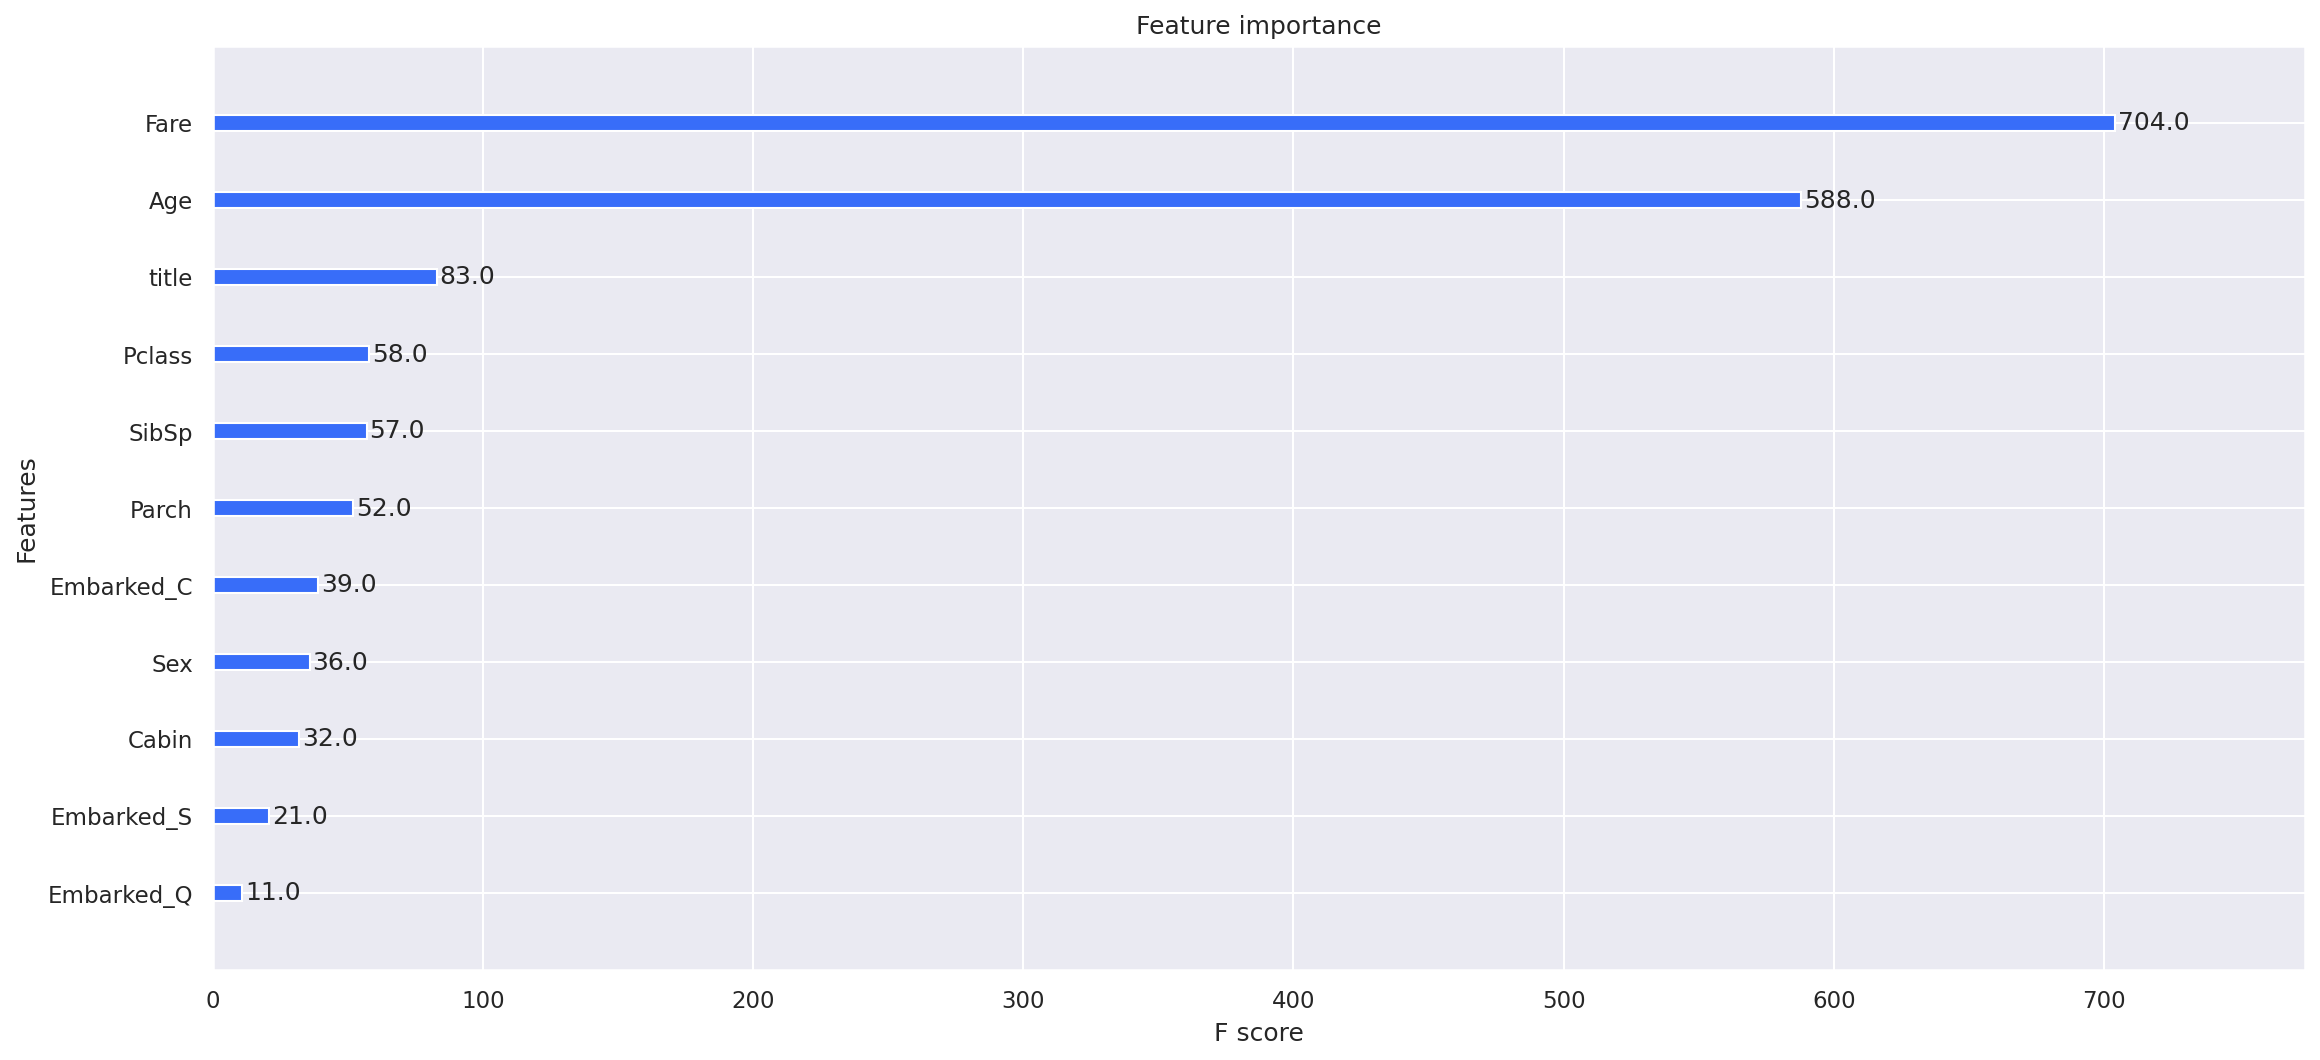

In [42]:
# @title $Feature \ \ Importance$

model=XGBClassifier(random_state=1234)
model.fit(X_train,y_train)
plot_importance(model)

## $Extreme \ \ Gradient \ \ Booster \ \ Model \ \ Using \ \ RandomizedSearchCV$

In [43]:
# @title $Hyperparameter \ \ Tunnig$
model = XGBClassifier(random_state=1234)
random_grid = { 'eta': [x for x in np.linspace(start=0.0, stop=0.5, num=12)],
               'n_estimators': [0,1,5,10,20,30,40,50,60,70,80,90,100,110,500,1000],
                'max_depth':range(0,10,1),
                'max_leaves':range(0,21,1),
                'tree_method':['auto', 'exact', 'approx', 'hist'],
                'colsample_bytree': [i/100.0 for i in range (91, 100, 1)],
                'min_child_weight': range(1,15,1),
                'gamma': [i/10.0 for i in range (0,5)],
                'subsample': [i/100.0 for i in range (60, 100, 5)],
                'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
                'learning_rate': [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
                }

In [44]:
# @title $Best \ \ Parameters$
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, cv = 5)

rf_random.fit(X_train, y_train)
print('Best Score :',rf_random.best_score_)
rf_random.best_params_

Best Score : 0.8160149709445484


{'tree_method': 'auto',
 'subsample': 0.8,
 'reg_alpha': 0.005,
 'n_estimators': 110,
 'min_child_weight': 10,
 'max_leaves': 12,
 'max_depth': 0,
 'learning_rate': 1,
 'gamma': 0.2,
 'eta': 0.2272727272727273,
 'colsample_bytree': 0.94}

In [45]:
# @title $XGBClassifier \ \ with \ \ best \ \ parameters$
model3 = XGBClassifier(tree_method='exact',
                          subsample=0.85,
                          reg_alpha=0.01,
                          n_estimators=1000,
                          min_child_weight=6,
                          max_leaves=2,
                          max_depth=8,
                          learning_rate=0.05,
                          gamma=0.2,
                          eta=0.4090909090909091,
                          colsample_bytree=0.93)


final_model(model3)

1) Train Accuracy : 0.925561797752809
2) Test Accuracy : 0.8379888268156425
3) Classification Report :
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       109
           1       0.80      0.79      0.79        70

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

4) ROC_AUC Score : 0.8286369593709043
5) Survived : 69
6) Not Survived :  110

7) Confusion Matrix :
[[95 14]
 [15 55]]


## $Extreme \ \ Gradient \ \ Booster \ \ Model \ \ Using \ \ GridSearchCV$

In [46]:
# @title $XGBClassifier$
model = XGBClassifier()
random_grid = {}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9775280898876404
2) Test Accuracy : 0.8379888268156425
3) Classification Report
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       109
           1       0.79      0.80      0.79        70

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

4) Best Score : 0.807613513247316
5) Best Parameters : {}
6) ROC_AUC Score : 0.8311926605504587
7) Confusion matrix : 
 [[94 15]
 [14 56]]



In [47]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ eta$
model = XGBClassifier()
random_grid = {'eta': [x for x in np.linspace(start=0.0, stop=0.5, num=12)]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9691011235955056
2) Test Accuracy : 0.8379888268156425
3) Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       109
           1       0.80      0.79      0.79        70

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

4) Best Score : 0.8202698709740963
5) Best Parameters : {'eta': 0.18181818181818182}
6) ROC_AUC Score : 0.8286369593709043
7) Confusion matrix : 
 [[95 14]
 [15 55]]



In [48]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ n-estimators$
model = XGBClassifier(eta=0.18181818181818182)
random_grid = {'n_estimators': [0,1,5,10,20,30,40,50,60,70,80,90,100,110,500,1000]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9550561797752809
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       109
           1       0.80      0.76      0.78        70

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.830089628681178
5) Best Parameters : {'n_estimators': 70}
6) ROC_AUC Score : 0.8189384010484928
7) Confusion matrix : 
 [[96 13]
 [17 53]]



In [49]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ max\_depth$
model = XGBClassifier(eta=0.18181818181818182, n_estimators=70,)
random_grid = {'max_depth':range(0,10,1)}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9550561797752809
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       109
           1       0.80      0.76      0.78        70

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.830089628681178
5) Best Parameters : {'max_depth': 6}
6) ROC_AUC Score : 0.8189384010484928
7) Confusion matrix : 
 [[96 13]
 [17 53]]



In [50]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ max\_leaves$
model = XGBClassifier(eta=0.18181818181818182, n_estimators=70, max_depth=6)
random_grid = {'max_leaves':range(0,21,1)}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9550561797752809
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       109
           1       0.80      0.76      0.78        70

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.830089628681178
5) Best Parameters : {'max_leaves': 0}
6) ROC_AUC Score : 0.8189384010484928
7) Confusion matrix : 
 [[96 13]
 [17 53]]



In [51]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ tree\_method$
model = XGBClassifier(eta=0.18181818181818182, n_estimators=70, max_depth=6, max_leaves=0)
random_grid = {'tree_method':['auto', 'exact', 'approx', 'hist']}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9550561797752809
2) Test Accuracy : 0.8324022346368715
3) Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       109
           1       0.80      0.76      0.78        70

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.830089628681178
5) Best Parameters : {'tree_method': 'auto'}
6) ROC_AUC Score : 0.8189384010484928
7) Confusion matrix : 
 [[96 13]
 [17 53]]



In [52]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ colsample\_bytree$
model = XGBClassifier(eta=0.18181818181818182, n_estimators=70, max_depth=6, max_leaves=0, tree_method='auto')
random_grid = {'colsample_bytree': [i/100.0 for i in range (91, 100, 1)]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.949438202247191
2) Test Accuracy : 0.8435754189944135
3) Classification Report
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       109
           1       0.83      0.76      0.79        70

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

4) Best Score : 0.8146262188515709
5) Best Parameters : {'colsample_bytree': 0.91}
6) ROC_AUC Score : 0.8281127129750983
7) Confusion matrix : 
 [[98 11]
 [17 53]]



In [53]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ gamma$
model = XGBClassifier(eta=0.18181818181818182, n_estimators=70, max_depth=6, max_leaves=0, tree_method='auto', colsample_bytree=0.91)
random_grid = {'gamma': [i/10.0 for i in range (0,5)]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.949438202247191
2) Test Accuracy : 0.8268156424581006
3) Classification Report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       109
           1       0.80      0.74      0.77        70

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) Best Score : 0.8258544272628778
5) Best Parameters : {'gamma': 0.1}
6) ROC_AUC Score : 0.8117955439056357
7) Confusion matrix : 
 [[96 13]
 [18 52]]



In [54]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ learning\_rate$
model = XGBClassifier(eta=0.18181818181818182, n_estimators=70, max_depth=6, max_leaves=0, tree_method='auto', colsample_bytree=0.91)
random_grid = {'learning_rate': [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9115168539325843
2) Test Accuracy : 0.8435754189944135
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       109
           1       0.86      0.71      0.78        70

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.84      0.84       179

4) Best Score : 0.8258642765685019
5) Best Parameters : {'learning_rate': 0.05}
6) ROC_AUC Score : 0.8204456094364352
7) Confusion matrix : 
 [[101   8]
 [ 20  50]]



In [55]:
# @title $Hyperparameter \ \ Tunning \ \ for \ \ min\_child\_weight$
model = XGBClassifier(eta=0.18181818181818182, n_estimators=70, max_depth=6, max_leaves=0, tree_method='auto', colsample_bytree=0.91, learning_rate=0.05)
random_grid = {'min_child_weight': range(1,15,1)}
hyperparameter_tuning(model, random_grid, X_train, y_train, X_test, y_test)

1) Train Accuracy : 0.9115168539325843
2) Test Accuracy : 0.8435754189944135
3) Classification Report
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       109
           1       0.86      0.71      0.78        70

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.84      0.84       179

4) Best Score : 0.8258642765685019
5) Best Parameters : {'min_child_weight': 1}
6) ROC_AUC Score : 0.8204456094364352
7) Confusion matrix : 
 [[101   8]
 [ 20  50]]



In [56]:
# @title $Final \ \ Model$
model4 = XGBClassifier(eta=0.18181818181818182, n_estimators=70, max_depth=6, max_leaves=0,
                      tree_method='auto', colsample_bytree=0.91, learning_rate=0.05,min_child_weight=1)

final_model(model4)

1) Train Accuracy : 0.9115168539325843
2) Test Accuracy : 0.8435754189944135
3) Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       109
           1       0.86      0.71      0.78        70

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.84      0.84       179

4) ROC_AUC Score : 0.8204456094364352
5) Survived : 58
6) Not Survived :  121

7) Confusion Matrix :
[[101   8]
 [ 20  50]]


#$Predictions \ \ for \ \ Test \ \ Dataset$

In [57]:
# @title $Import \ \ Test \ \ Dataset$

test_data = pd.read_csv('Titanic_test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [58]:
# @title $Test \ \ Dataset \ \ Info$

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [59]:
# @title $Imputation$
# @markdown Fill NaN entries in 'Age' and 'Fare' columns of test data by the median of 'Age' and 'Fare' columns of train data

test_data['Age'].fillna(med_age, inplace=True)
test_data['Fare'].fillna(med_fare, inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [60]:
# @title $Convert \ \  Cabin \ \ Column \ \ into \ \ Binary$

test_data["Cabin"] = test_data["Cabin"].isna() # If cabin is there then 1, 0 for no cabin
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    bool   
 10  Embarked     418 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 33.2+ KB


In [61]:
# @title $Create \ \ a \ \ new \ \ column \ \ "Title" \ \ from \ \ an \ \ existing \ \ column \ \ "Name"$
# Splitting based on Title
def get_title(name):
    if "." in name:
        return name.split(",")[1].split(".")[0].strip()
    else:
        return "Unknown"

def title_map(title):
    if title in ["Mr"]:
        return 1
    elif title in ["Master"]:
        return 3
    elif title in ["Ms", "Mlle", "Miss"]:
        return 4
    elif title in ["Mme","Mrs"]:
        return 5
    else:
        return 2

test_data["title"] = test_data["Name"].apply(get_title).apply(title_map)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    bool   
 10  Embarked     418 non-null    object 
 11  title        418 non-null    int64  
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 36.5+ KB


In [62]:
# @title $Drop \ \ Columns \ \ "PassengerId", \ \ "Name" \ \ and \ \ "Ticket" $
test_data = test_data.drop(["PassengerId","Name","Ticket"], axis=1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Cabin     418 non-null    bool   
 7   Embarked  418 non-null    object 
 8   title     418 non-null    int64  
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 26.7+ KB


#$Encoding$

In [63]:
# @title $Label \ \  Encoding \ \ on \ \ column \ \ Sex$
le = LabelEncoder()

ec_test_data = test_data.copy()
ec_test_data['Sex']= le.fit_transform(ec_test_data['Sex'])
#ec_train_data['Embarked']= le.fit_transform(ec_train_data['Embarked'])
ec_test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title
0,3,1,34.5,0,0,7.8292,True,Q,1
1,3,0,47.0,1,0,7.0000,True,S,5
2,2,1,62.0,0,0,9.6875,True,Q,1
3,3,1,27.0,0,0,8.6625,True,S,1
4,3,0,22.0,1,1,12.2875,True,S,5


In [64]:
# @title $OneHotEncoding \ \ on \ \ column \ \ Embarked $

ec_test_data = pd.get_dummies(ec_test_data, columns=['Embarked'], dtype=int)
ec_test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,title,Embarked_C,Embarked_Q,Embarked_S
0,3,1,34.5,0,0,7.8292,True,1,0,1,0
1,3,0,47.0,1,0,7.0000,True,5,0,0,1
2,2,1,62.0,0,0,9.6875,True,1,0,1,0
3,3,1,27.0,0,0,8.6625,True,1,0,0,1
4,3,0,22.0,1,1,12.2875,True,5,0,0,1


In [65]:
# @title $Perform \ \ Capping \ \ on \ \ all \ \ numerical \ \ columns \ \ as \ \ Max \ \ and \ \ Min \ \ Values \ \ from \ \ Train \ \ Dataset$

def min_max_detection(data, col_name):
    min = data[col_name].min()
    max = data[col_name].max()

    return (min,max)

# Dictionary for lower and upper extreme
min_max = {}
for col in X.columns.tolist():
    min_max[col] = min_max_detection(ec_train_data, col)

# Outliers Capping
for col in min_max.keys():
    ec_test_data.loc[ec_test_data[col] < min_max[col][0] , col]=min_max[col][0]
    ec_test_data.loc[ec_test_data[col] > min_max[col][1] , col]=min_max[col][1]


ec_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    int64  
 2   Age         418 non-null    float64
 3   SibSp       418 non-null    int64  
 4   Parch       418 non-null    int64  
 5   Fare        418 non-null    float64
 6   Cabin       418 non-null    bool   
 7   title       418 non-null    int64  
 8   Embarked_C  418 non-null    int64  
 9   Embarked_Q  418 non-null    int64  
 10  Embarked_S  418 non-null    int64  
dtypes: bool(1), float64(2), int64(8)
memory usage: 33.2 KB


In [66]:
# @title $Light \ \ Gradient \ \ Boosting \ \ Classifier \ \ Model \ \ Using \ \ RandomizedSearchCV$
y_pred1 = model1.predict(ec_test_data)
y_pred1

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [67]:
# @title $Model \ \ Performance$
final_model(model1)

1) Train Accuracy : 0.8862359550561798
2) Test Accuracy : 0.8379888268156425
3) Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.93      0.87       109
           1       0.86      0.70      0.77        70

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179

4) ROC_AUC Score : 0.813302752293578
5) Survived : 57
6) Not Survived :  122

7) Confusion Matrix :
[[101   8]
 [ 21  49]]


In [68]:
# @title $Light \ \ Gradient \ \ Boosting  \ \ Classifier \ \ Model \ \ Using \ \ GridSearchCV$
y_pred2 = model2.predict(ec_test_data)
y_pred2

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [69]:
# @title $Model \ \ Performance$
final_model(model2)

1) Train Accuracy : 0.8974719101123596
2) Test Accuracy : 0.8324022346368715
3) Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       109
           1       0.83      0.71      0.77        70

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

4) ROC_AUC Score : 0.8112712975098297
5) Survived : 60
6) Not Survived :  119

7) Confusion Matrix :
[[99 10]
 [20 50]]


In [70]:
# @title $Extreme \ \ Gradient \ \ Booster \ \ Classifier \ \ Model \ \ Using \ \ RandomizedSearchCV$
y_pred3 = model3.predict(ec_test_data)
y_pred3

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [71]:
# @title $Model \ \ Performance$
final_model(model3)

1) Train Accuracy : 0.925561797752809
2) Test Accuracy : 0.8379888268156425
3) Classification Report :
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       109
           1       0.80      0.79      0.79        70

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

4) ROC_AUC Score : 0.8286369593709043
5) Survived : 69
6) Not Survived :  110

7) Confusion Matrix :
[[95 14]
 [15 55]]


In [72]:
# @title $Extreme \ \ Gradient \ \ Booster \ \ Classifier \ \ Model \ \ Using \ \ GridSearchCV$
y_pred4 = model4.predict(ec_test_data)
y_pred4

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [73]:
# @title $Model \ \ Performance$
final_model(model4)

1) Train Accuracy : 0.9115168539325843
2) Test Accuracy : 0.8435754189944135
3) Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       109
           1       0.86      0.71      0.78        70

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.84      0.84       179

4) ROC_AUC Score : 0.8204456094364352
5) Survived : 58
6) Not Survived :  121

7) Confusion Matrix :
[[101   8]
 [ 20  50]]


In [74]:
# @title $Finally \ \ we \ \ take \ \ mode \ \ of \ \ above \ \ four \ \ models$
test_data['Survived1'] = y_pred1
test_data['Survived2'] = y_pred2
test_data['Survived3'] = y_pred3
test_data['Survived4'] = y_pred4

test_data.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title,Survived1,Survived2,Survived3,Survived4
0,3,male,34.5,0,0,7.8292,True,Q,1,0,0,0,0
1,3,female,47.0,1,0,7.0000,True,S,5,0,0,0,0
2,2,male,62.0,0,0,9.6875,True,Q,1,0,0,0,0
3,3,male,27.0,0,0,8.6625,True,S,1,0,0,0,0
4,3,female,22.0,1,1,12.2875,True,S,5,1,0,1,1
5,3,male,14.0,0,0,9.2250,True,S,1,0,0,0,0
6,3,female,30.0,0,0,7.6292,True,Q,4,1,0,0,0
7,2,male,26.0,1,1,29.0000,True,S,1,0,0,0,0
8,3,female,18.0,0,0,7.2292,True,C,5,1,1,1,1
9,3,male,21.0,2,0,24.1500,True,S,1,0,0,0,0


#$4: Comparative \ \ Analysis:$

i) accuracy, precision, recall of all four models are more in XGBM compared to LGBM, but not much difference

ii) XGB Models are overfitted compared to LGB Models

### **XGBoost (XGBM)**
####**Strengths:**

**Accuracy:** XGBoost often delivers highly accurate results due to its advanced implementation of gradient boosting.

**Robustness:** It handles a variety of data types and is robust to overfitting through techniques like regularization.

**Feature Engineering:** XGBoost includes many built-in tools for feature selection and model tuning, making it a versatile choice.

**Handling Sparse Data:** XGBoost efficiently handles sparse data, which is common in many real-world applications.

**Parallelization:** It supports parallel processing, which can significantly speed up training times.

####**Weaknesses:**

**Training Time:** Despite optimizations, XGBoost can be slower to train compared to some other models, especially on large datasets.

**Memory Usage:** It can consume a lot of memory, which might be a constraint for very large datasets.

**Complexity:** XGBoost's numerous parameters and settings can make it complex to configure optimally without sufficient experience.

###**LightGBM (LGBM)**

####**Strengths:**

**Speed:** LightGBM is typically faster than XGBoost, especially with large datasets, due to its optimized histogram-based algorithms.

**Efficiency:** It consumes less memory and is designed to handle large datasets more efficiently.

**Accuracy:** LightGBM provides comparable accuracy to XGBoost but achieves it faster.

**Support for GPU Training:** LightGBM has strong support for GPU training, further speeding up the training process.

**Large Scale:** It is particularly effective for very large datasets and high-dimensional data.

####**Weaknesses:**

**Overfitting:** LightGBM can sometimes be more prone to overfitting, particularly with small datasets or insufficient regularization.

**Complexity of Customization:** While LightGBM is efficient, it can be less intuitive to customize for specific tasks compared to XGBoost.

**Sparse Data Handling:** Although LightGBM can handle sparse data, it is generally less efficient at this compared to XGBoost.

###**Summary**
XGBoost is favored for its robustness, accuracy, and comprehensive feature set but can be slower and more memory-intensive.

LightGBM is preferred for its speed, efficiency, and ability to handle large-scale datasets but might require more care to avoid overfitting and might be less straightforward to customize.